# Plan 0 preliminary K comparison (FA vs FactoSig)

This notebook is a **lightweight, preliminary** analysis of the existing Plan 0 experiment results (single seed) stored under:

- `sc_classification/experiments/20260211_212806_plan0_k_sweep_60_none_hvg_c06f4886`

We focus on **K in {20, 40, 60}** and compare **FA vs FactoSig** using:

- **Score-variance share** per factor (sorted) as a cross-method comparable “knee drop” diagnostic
- Optional overlays of **label-alignment** proxies (corr/AUC) per factor
- **Gene communality** distribution per method and K (method-specific but useful shape diagnostic)
- **Cross-method factor alignment** (loading correlations) for interpretability/consistency

Notes:
- Factors are **reordered for plotting only** (descending score variance) to make “knee” comparisons visually consistent. This does **not** change cached results.
- This experiment currently has **FA/FactoSig** caches for seed=1. PCA caches were missing in this directory at audit time.


In [1]:
from __future__ import annotations

from pathlib import Path
import json
import numpy as np
import pandas as pd
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")
plt.rcParams["figure.dpi"] = 120

EXP_DIR = Path("/home/minhang/mds_project/sc_classification/experiments/20260211_212806_plan0_k_sweep_60_none_hvg_c06f4886")
PRE_DIR = EXP_DIR / "preprocessing"

H5ADS = {
    20: PRE_DIR / "adata_processed_with_plan0_dr_k20_seed1.h5ad",
    40: PRE_DIR / "adata_processed_with_plan0_dr_k40_seed1.h5ad",
    60: PRE_DIR / "adata_processed_with_plan0_dr_k60_seed1.h5ad",
}

OUT_DIR = EXP_DIR / "analysis" / "plan0" / "prelim_k_compare_notebook"
OUT_DIR.mkdir(parents=True, exist_ok=True)

METHOD_KEYS = {
    "fa": ("X_fa", "FA_loadings", "fa"),
    "factosig": ("X_factosig", "FACTOSIG_loadings", "factosig"),
}

# label mapping helper (CN.label is usually {cancer, normal})
POS_LABEL = "cancer"
LABEL_COL = "CN.label"

print("OUT_DIR:", OUT_DIR)
for k, p in H5ADS.items():
    print(k, p, "exists=", p.exists())


OUT_DIR: /home/minhang/mds_project/sc_classification/experiments/20260211_212806_plan0_k_sweep_60_none_hvg_c06f4886/analysis/plan0/prelim_k_compare_notebook
20 /home/minhang/mds_project/sc_classification/experiments/20260211_212806_plan0_k_sweep_60_none_hvg_c06f4886/preprocessing/adata_processed_with_plan0_dr_k20_seed1.h5ad exists= True
40 /home/minhang/mds_project/sc_classification/experiments/20260211_212806_plan0_k_sweep_60_none_hvg_c06f4886/preprocessing/adata_processed_with_plan0_dr_k40_seed1.h5ad exists= True
60 /home/minhang/mds_project/sc_classification/experiments/20260211_212806_plan0_k_sweep_60_none_hvg_c06f4886/preprocessing/adata_processed_with_plan0_dr_k60_seed1.h5ad exists= True


In [2]:
def load_adata_k(k: int, backed: bool = True):
    p = H5ADS[int(k)]
    if not p.exists():
        raise FileNotFoundError(p)
    # backed='r' avoids loading the whole ~5GB object into RAM
    ad = sc.read_h5ad(str(p), backed="r") if backed else sc.read_h5ad(str(p))
    return ad


def get_label_vector(ad) -> np.ndarray:
    if LABEL_COL not in ad.obs.columns:
        raise KeyError(f"Missing ad.obs[{LABEL_COL!r}]")
    y_raw = ad.obs[LABEL_COL]
    # tolerate bool/int/str
    if pd.api.types.is_bool_dtype(y_raw):
        return y_raw.astype(int).to_numpy()
    if pd.api.types.is_numeric_dtype(y_raw):
        # assume already 0/1-ish
        return (y_raw.astype(float) > 0).astype(int).to_numpy()
    y = y_raw.astype(str)
    return (y == POS_LABEL).astype(int).to_numpy()


def get_scores_loadings_uns(ad, method: str):
    score_key, loading_key, uns_key = METHOD_KEYS[method]
    if score_key not in ad.obsm_keys():
        raise KeyError(f"Missing {score_key} in obsm")
    if loading_key not in ad.varm_keys():
        raise KeyError(f"Missing {loading_key} in varm")
    Z = np.asarray(ad.obsm[score_key])
    L = np.asarray(ad.varm[loading_key])
    meta = dict(ad.uns.get(uns_key, {}))
    return Z, L, meta


def variance_share(Z: np.ndarray) -> np.ndarray:
    # per-factor variance share; center each factor
    Zc = Z - Z.mean(axis=0, keepdims=True)
    v = np.var(Zc, axis=0)
    s = v / (v.sum() + 1e-12)
    return s


def reorder_by_share(Z: np.ndarray, L: np.ndarray, share: np.ndarray):
    order = np.argsort(share)[::-1]
    return Z[:, order], L[:, order], share[order], order


In [4]:
# Load minimal matrices into memory (scores+loadings) for each K and method
DR = {}  # DR[(k, method)] = dict(Z, L, meta, share, share_sorted)

for k in sorted(H5ADS):
    ad = load_adata_k(k, backed=True)
    y = get_label_vector(ad)
    for m in ["fa", "factosig"]:
        Z, L, meta = get_scores_loadings_uns(ad, m)
        share = variance_share(Z)
        Zs, Ls, shares, order = reorder_by_share(Z, L, share)
        DR[(k, m)] = {
            "Z": Z,
            "L": L,
            "meta": meta,
            "share": share,
            "Z_sorted": Zs,
            "L_sorted": Ls,
            "share_sorted": shares,
            "order": order,
            "y": y,
            "var_names": np.array(ad.var_names),
        }

print("Loaded entries:", len(DR))


Loaded entries: 6


## 1) Knee-drop (score-variance share)

We plot per-factor variance share in latent scores, **sorted descending**. This provides a comparable diagnostic across FA and FactoSig.

Interpretation reminders:
- A sharper drop suggests a few dominant global axes.
- A flatter tail suggests many moderate axes.
- Low-variance factors can still be strongly **label-aligned** (checked below).

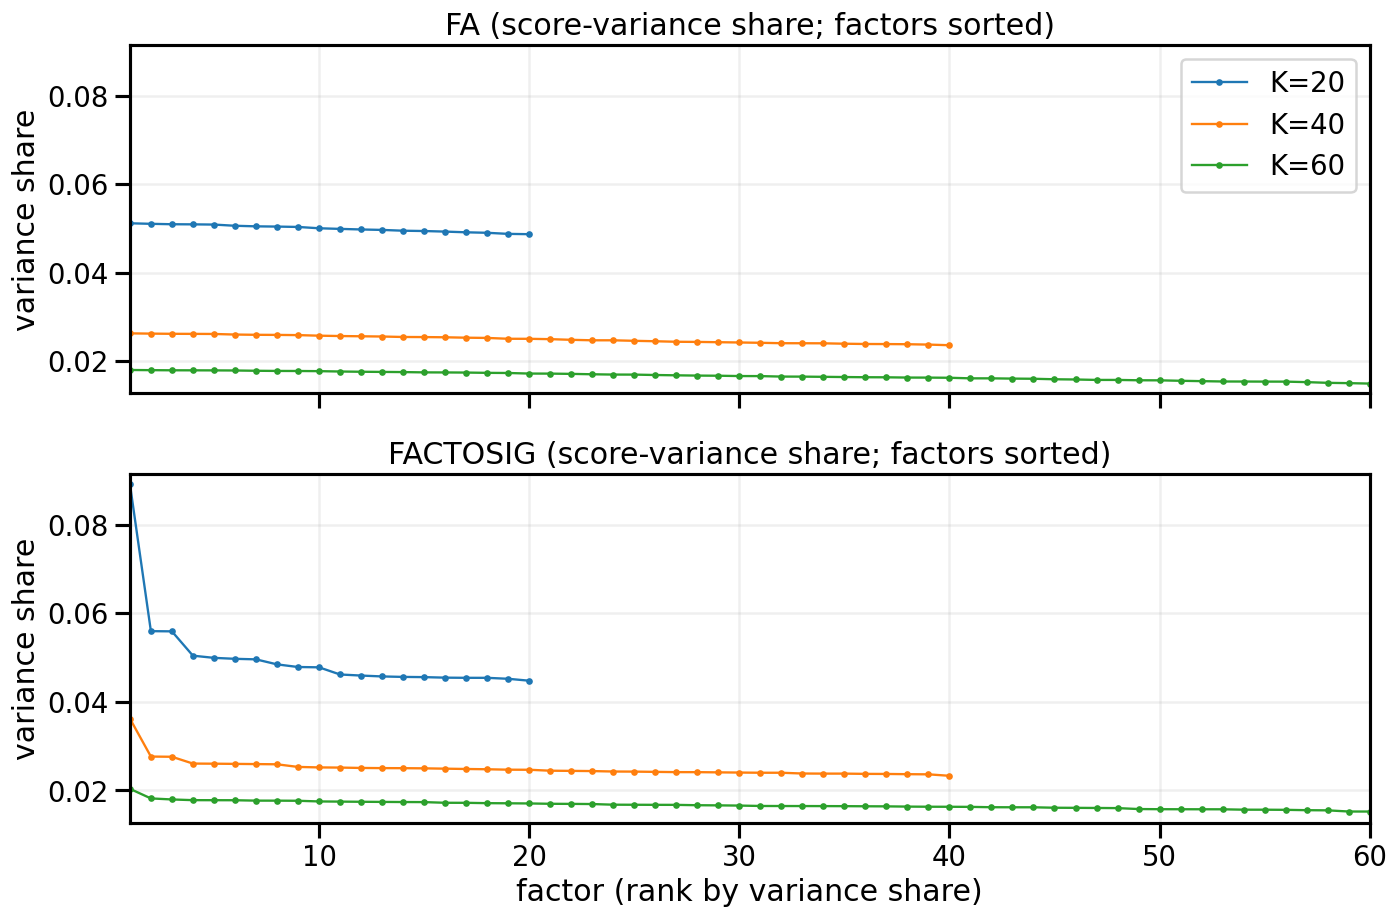

Saved: /home/minhang/mds_project/sc_classification/experiments/20260211_212806_plan0_k_sweep_60_none_hvg_c06f4886/analysis/plan0/prelim_k_compare_notebook/knee_score_variance_share_overlay_fa_factosig.png


In [5]:
Ks = [20, 40, 60]
methods = ["fa", "factosig"]
colors = dict(zip(Ks, sns.color_palette("tab10", n_colors=len(Ks))))

# shared y-limits across both methods for easier comparison
all_shares = [DR[(k, m)]["share_sorted"] for k in Ks for m in methods]
ymin = min(float(np.min(s)) for s in all_shares)
ymax = max(float(np.max(s)) for s in all_shares)
pad = 0.03 * (ymax - ymin + 1e-12)

ylim = (ymin - pad, ymax + pad)

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True, sharey=True)

for row, m in enumerate(methods):
    ax = axes[row]
    for k in Ks:
        shares = DR[(k, m)]["share_sorted"]
        x = np.arange(1, len(shares) + 1)
        ax.plot(x, shares, marker="o", ms=3, lw=1.4, color=colors[k], label=f"K={k}")

    ax.set_title(f"{m.upper()} (score-variance share; factors sorted)")
    ax.set_ylabel("variance share")
    ax.set_xlim(1, max(Ks))
    ax.set_ylim(*ylim)
    ax.grid(True, alpha=0.2)

axes[-1].set_xlabel("factor (rank by variance share)")
axes[0].legend(loc="upper right", frameon=True)

plt.tight_layout()
fig_path = OUT_DIR / "knee_score_variance_share_overlay_fa_factosig.png"
plt.savefig(fig_path, dpi=160)
plt.show()
print("Saved:", fig_path)


## 2) Additional K-choice criteria (quick proxies)

With only one seed, we can’t yet use stability/consensusness. Here are two fast, informative proxies:

- **Label-alignment per factor**: correlation between each factor score and `CN.label` (global; patient-level comes later).
- **Embedding-only AUC**: a quick logistic regression AUC using all k factors (not CV; just a sanity proxy).

These help answer: *do larger K values introduce useful label-aligned factors even if they’re low-variance?*

In [6]:
def factor_label_corrs(Z: np.ndarray, y: np.ndarray) -> np.ndarray:
    # Pearson correlation of each factor with binary y
    y0 = y.astype(float) - float(np.mean(y))
    y0 = y0 / (np.linalg.norm(y0) + 1e-12)
    Zc = Z - Z.mean(axis=0, keepdims=True)
    Zc = Zc / (np.linalg.norm(Zc, axis=0, keepdims=True) + 1e-12)
    # corr between each factor and the label
    corr = (y0[:, None] * Zc).sum(axis=0)

    return corr


def quick_auc_lr(Z: np.ndarray, y: np.ndarray) -> float:
    '''
        This function is used to calculate the AUC of the logistic regression model.
        Using all k factors to predict the label.
    '''
    try:
        from sklearn.linear_model import LogisticRegression
        from sklearn.metrics import roc_auc_score
    except Exception:
        return np.nan
    # simple split-less AUC (proxy only)
    clf = LogisticRegression(max_iter=500, solver="liblinear")
    clf.fit(Z, y)
    p = clf.predict_proba(Z)[:, 1]
    return float(roc_auc_score(y, p))


rows = []
for k in [20, 40, 60]:
    for m in ["fa", "factosig"]:
        Zs = DR[(k, m)]["Z_sorted"]
        y = DR[(k, m)]["y"]
        corr = factor_label_corrs(Zs, y)
        auc = quick_auc_lr(Zs, y)
        rows.append(
            {
                "k": int(k),
                "method": m,
                "auc_proxy": auc,
                "max_abs_corr": float(np.max(np.abs(corr))), # the max abs corr factor
                "top_corr_factor_idx_sorted": int(np.argmax(np.abs(corr)) + 1), # the index of the max abs corr factor
            }
        )

df = pd.DataFrame(rows).sort_values(["method", "k"])
display(df)


,k,method,auc_proxy,max_abs_corr,top_corr_factor_idx_sorted
0,20,fa,0.911734,0.101201,9
2,40,fa,0.953546,0.496466,21
4,60,fa,0.983723,0.488940,22
1,20,factosig,0.907782,0.163863,5
3,40,factosig,0.958217,0.584797,19
5,60,factosig,0.985311,0.579771,18


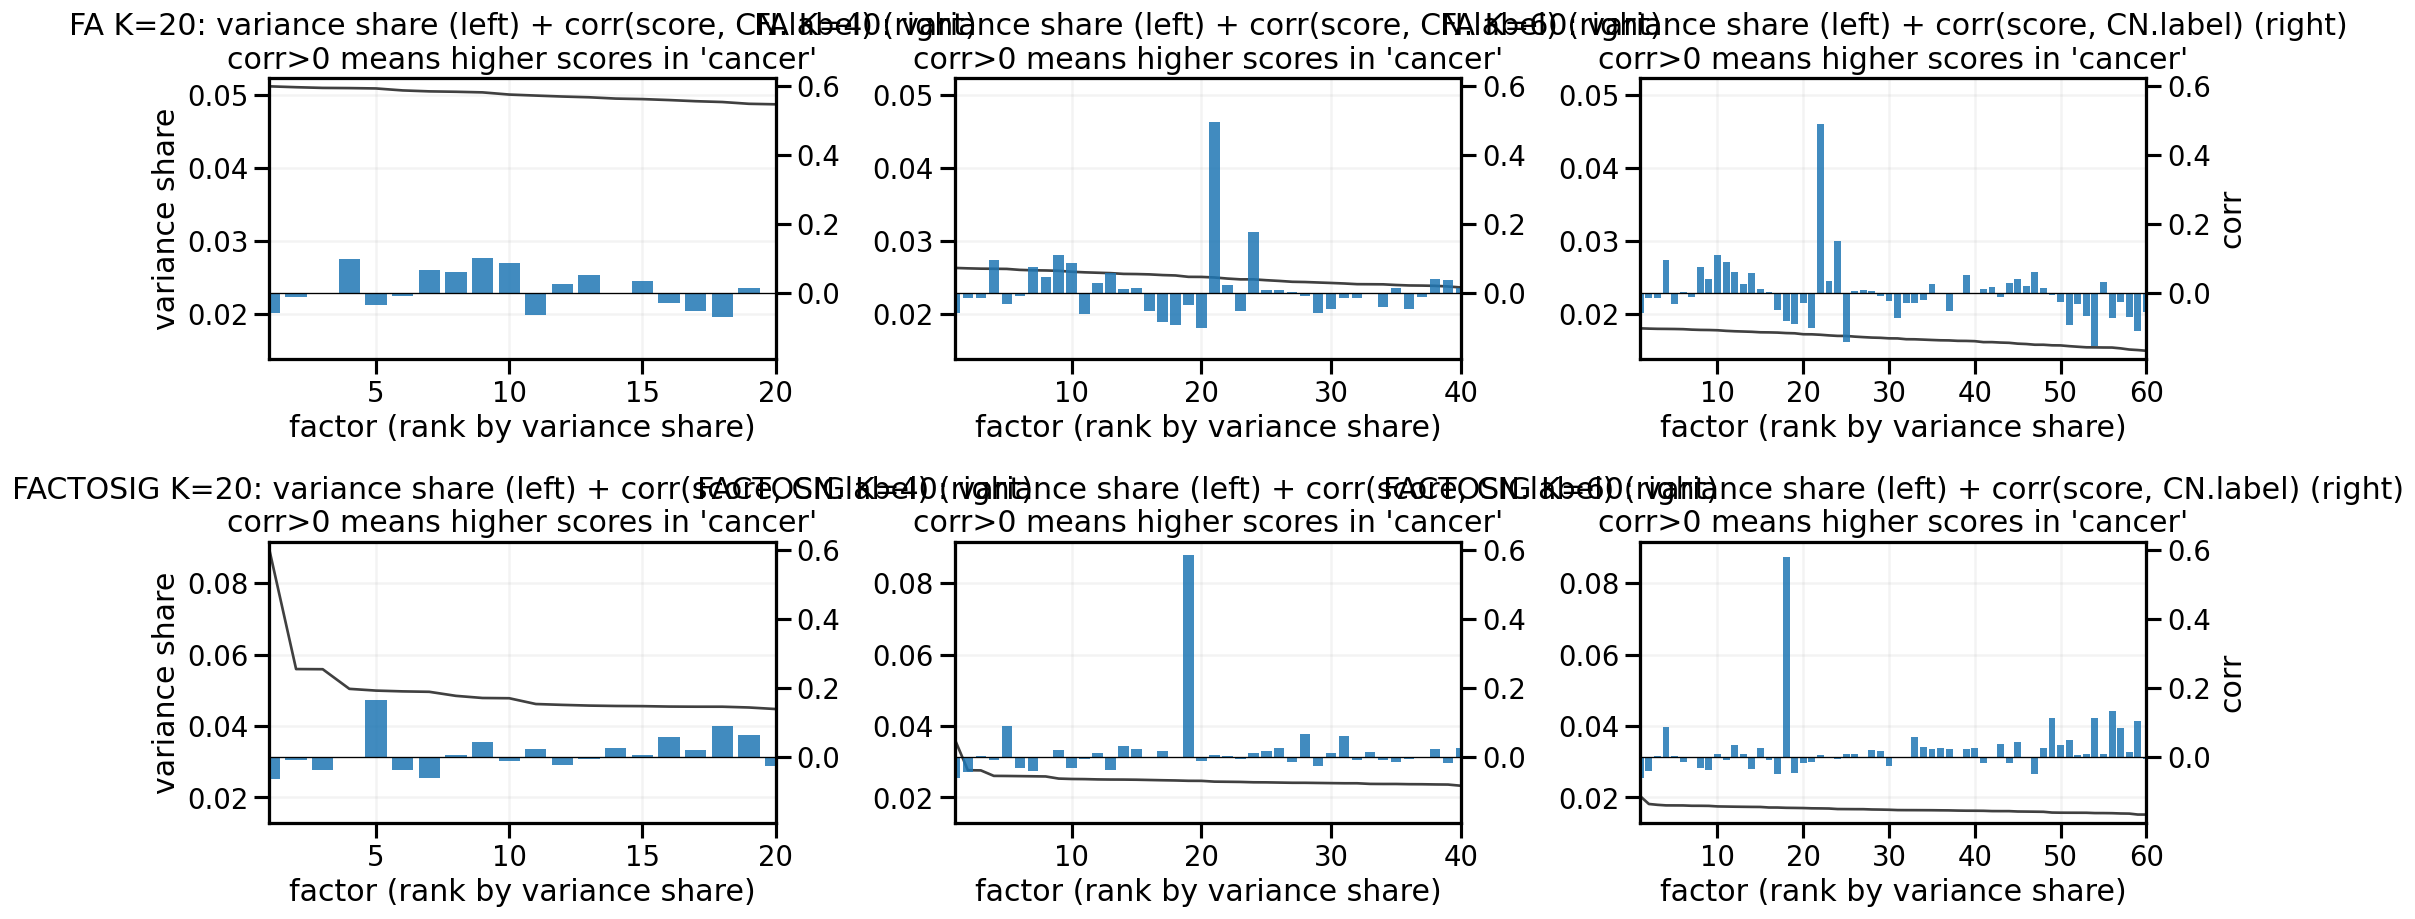

Saved: /home/minhang/mds_project/sc_classification/experiments/20260211_212806_plan0_k_sweep_60_none_hvg_c06f4886/analysis/plan0/prelim_k_compare_notebook/label_corr_and_share_by_factor_sorted_twinaxis.png


In [7]:
Ks = [20, 40, 60]
methods = ["fa", "factosig"]

# Global corr limits for comparability
all_corr = []
for k in Ks:
    for m in methods:
        Zs = DR[(k, m)]["Z_sorted"]
        y = DR[(k, m)]["y"]
        all_corr.append(factor_label_corrs(Zs, y))

cmin = min(float(np.min(c)) for c in all_corr)
cmax = max(float(np.max(c)) for c in all_corr)
cpad = 0.05 * (cmax - cmin + 1e-12)
corr_ylim = (cmin - cpad, cmax + cpad)

# Method-specific share limits (left axis)
share_ylim = {}
for m in methods:
    ss = [DR[(k, m)]["share_sorted"] for k in Ks]
    smin = min(float(np.min(s)) for s in ss)
    smax = max(float(np.max(s)) for s in ss)
    spad = 0.03 * (smax - smin + 1e-12)
    share_ylim[m] = (smin - spad, smax + spad)

fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharex=False)

for col, k in enumerate(Ks):
    for row, m in enumerate(methods):
        ax_share = axes[row, col]
        ax_corr = ax_share.twinx()

        shares = DR[(k, m)]["share_sorted"]
        Zs = DR[(k, m)]["Z_sorted"]
        y = DR[(k, m)]["y"]
        corr = factor_label_corrs(Zs, y)

        x_share = np.arange(1, len(shares) + 1)
        x_corr = np.arange(1, len(corr) + 1)

        ax_share.plot(x_share, shares, color="0.25", lw=1.6)
        ax_share.set_ylim(*share_ylim[m])
        ax_share.set_xlim(1, k)

        ax_corr.bar(x_corr, corr, color="#1f77b4", alpha=0.85)
        ax_corr.axhline(0, color="k", lw=0.8)
        ax_corr.set_ylim(*corr_ylim)

        ax_share.set_title(
            f"{m.upper()} K={k}: variance share (left) + corr(score, {LABEL_COL}) (right)\n"
            f"corr>0 means higher scores in {POS_LABEL!r}"
        )
        ax_share.set_xlabel("factor (rank by variance share)")

        if col == 0:
            ax_share.set_ylabel("variance share")
        if col == len(Ks) - 1:
            ax_corr.set_ylabel("corr")

        ax_share.grid(True, alpha=0.15)

plt.tight_layout()
fig_path = OUT_DIR / "label_corr_and_share_by_factor_sorted_twinaxis.png"
plt.savefig(fig_path, dpi=160)
plt.show()
print("Saved:", fig_path)


## 3) Gene communality distributions (shape diagnostics)

We compute a simple proxy per gene:

\[
\mathrm{comm}_g = \sum_{j=1}^k L_{g j}^2
\]

This is **not perfectly comparable** across methods (scaling/rotation/non-orthogonality), but the **distribution shape** can still be informative.

We plot `log10(1 + comm)` to stabilize scale.

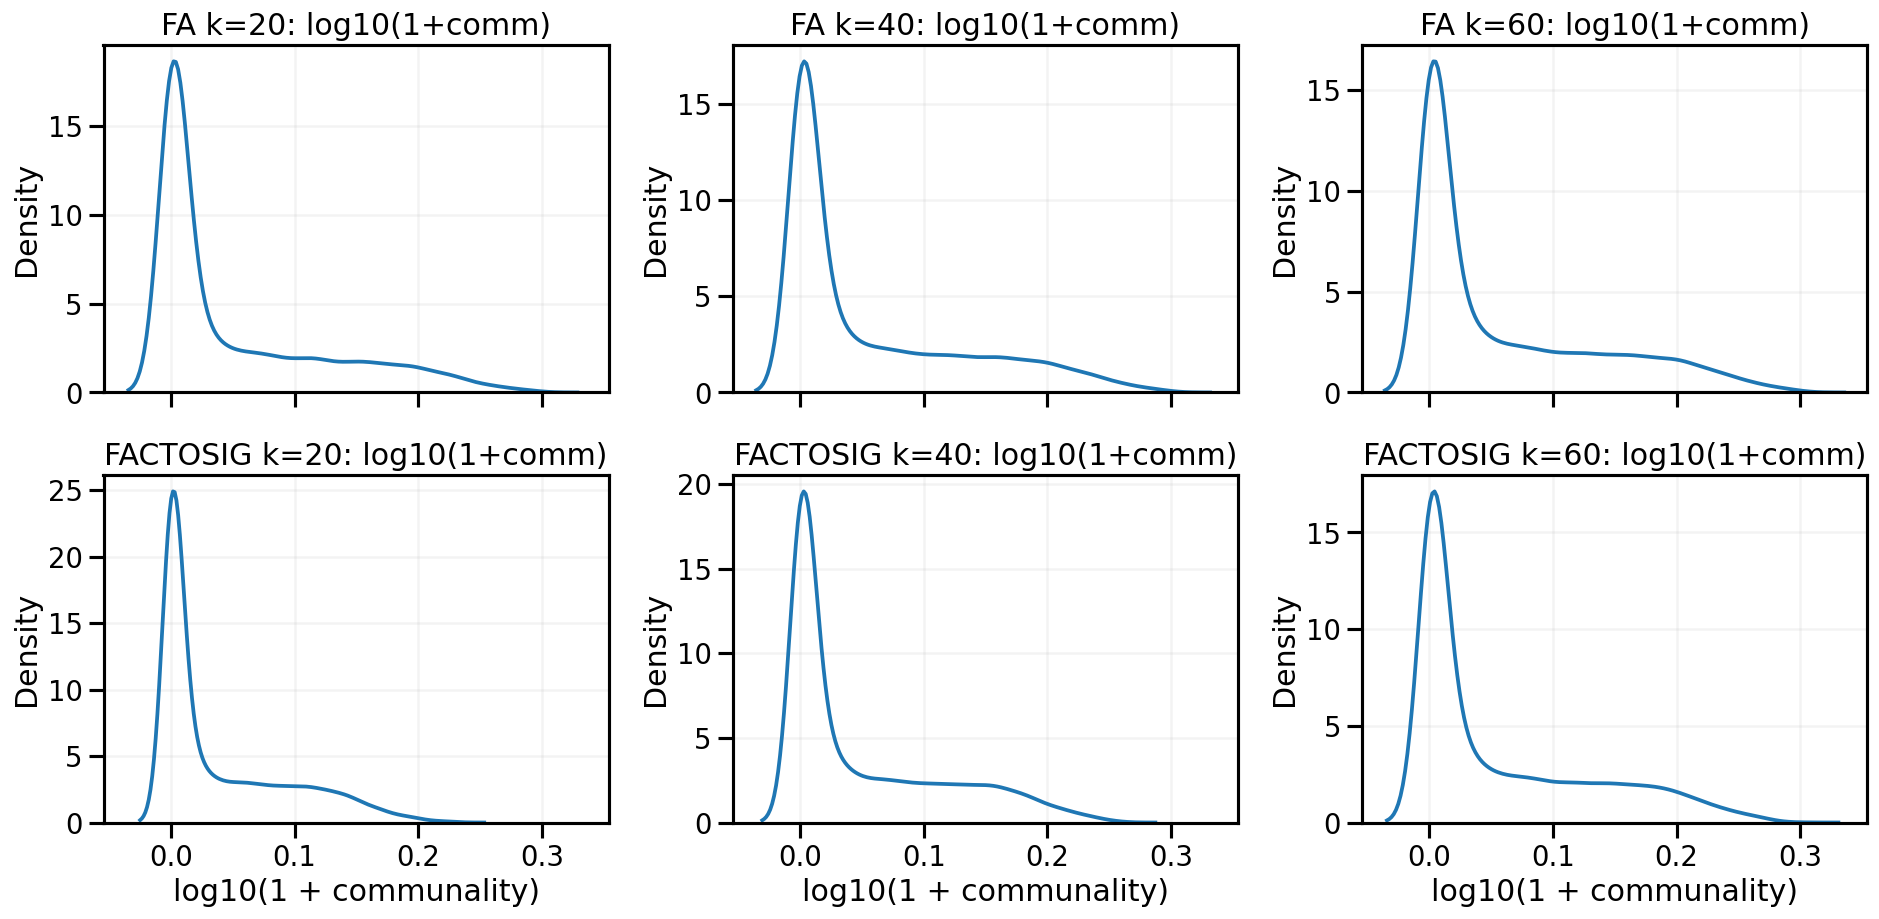

Saved: /home/minhang/mds_project/sc_classification/experiments/20260211_212806_plan0_k_sweep_60_none_hvg_c06f4886/analysis/plan0/prelim_k_compare_notebook/communality_kde_log10.png


In [8]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=True, sharey=False)

for col, k in enumerate([20, 40, 60]):
    for row, m in enumerate(["fa", "factosig"]):
        ax = axes[row, col]
        Ls = DR[(k, m)]["L_sorted"]
        comm = (Ls**2).sum(axis=1)
        x = np.log10(1.0 + comm)
        sns.kdeplot(x, ax=ax, fill=False)
        ax.set_title(f"{m.upper()} k={k}: log10(1+comm)")
        ax.set_xlabel("log10(1 + communality)")
        ax.grid(True, alpha=0.15)

plt.tight_layout()
fig_path = OUT_DIR / "communality_kde_log10.png"
plt.savefig(fig_path, dpi=160)
plt.show()
print("Saved:", fig_path)


## 4) Cross-method factor alignment (FA vs FactoSig)

For each K, we correlate factors by gene loadings.

- Here we use **Spearman** across genes for robustness.
- Then we show the heatmap and report best-match summaries.

This helps answer: *are the two methods capturing similar gene programs at a given K?*

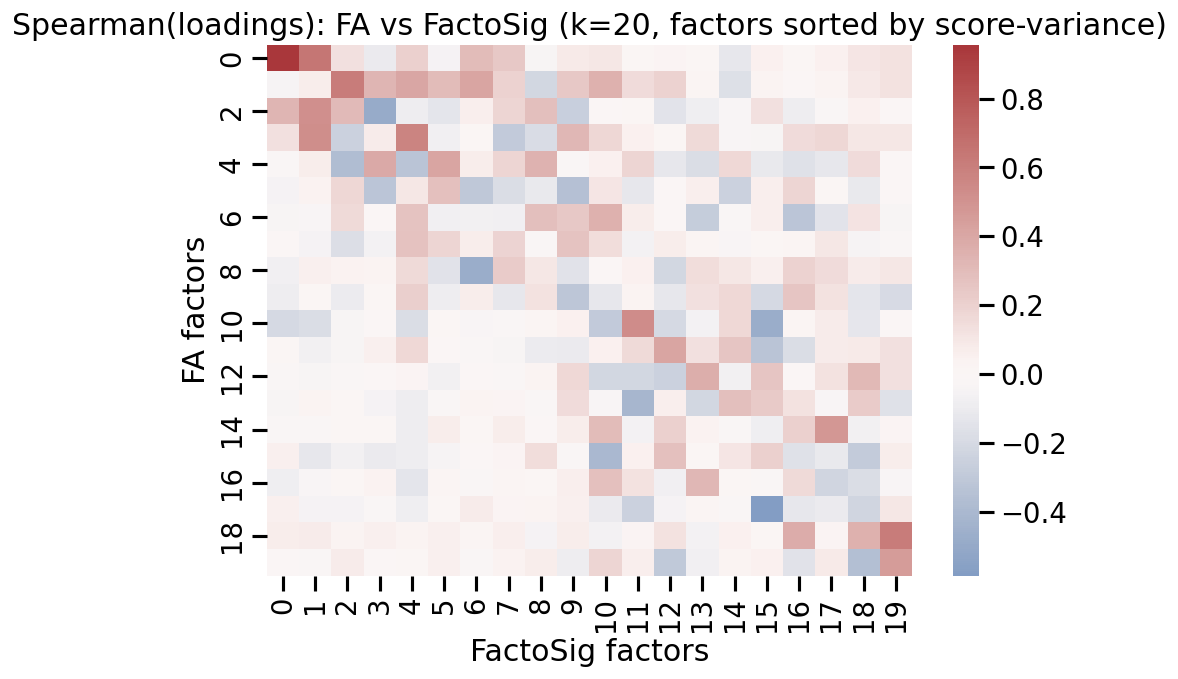

Saved: /home/minhang/mds_project/sc_classification/experiments/20260211_212806_plan0_k_sweep_60_none_hvg_c06f4886/analysis/plan0/prelim_k_compare_notebook/spearman_heatmap_fa_vs_factosig_k20.png
k=20: FA→FS best median=0.392, mean=0.417
k=20: FS→FA best median=0.405, mean=0.448



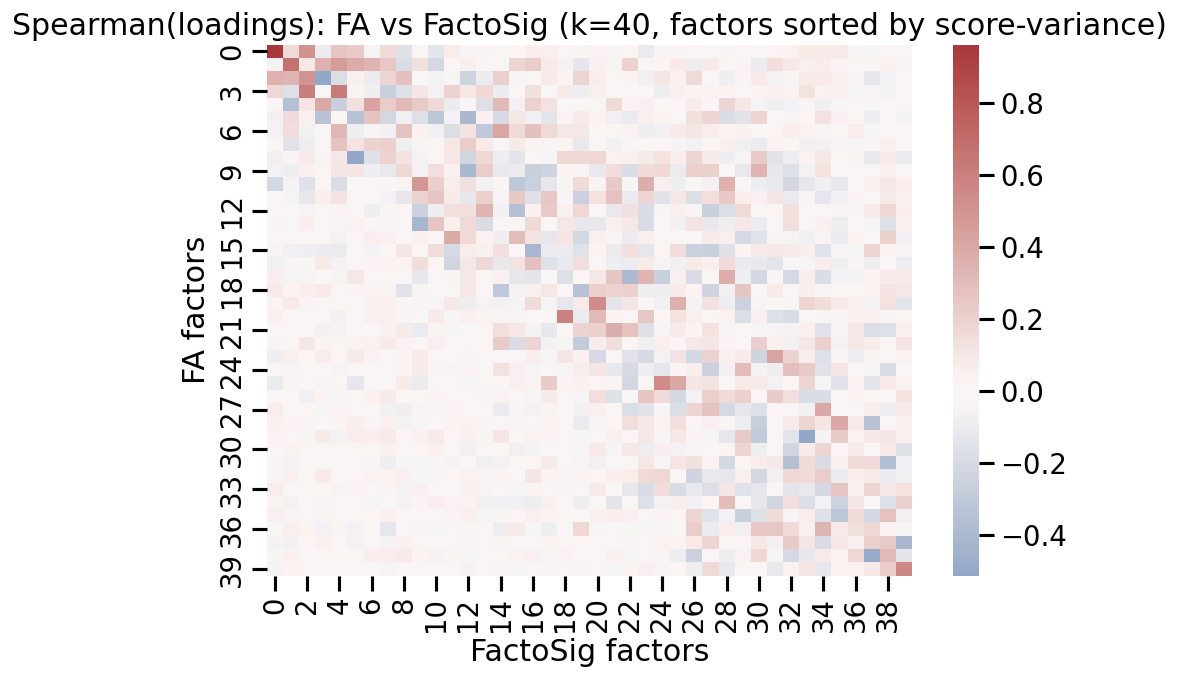

Saved: /home/minhang/mds_project/sc_classification/experiments/20260211_212806_plan0_k_sweep_60_none_hvg_c06f4886/analysis/plan0/prelim_k_compare_notebook/spearman_heatmap_fa_vs_factosig_k40.png
k=40: FA→FS best median=0.324, mean=0.366
k=40: FS→FA best median=0.372, mean=0.384



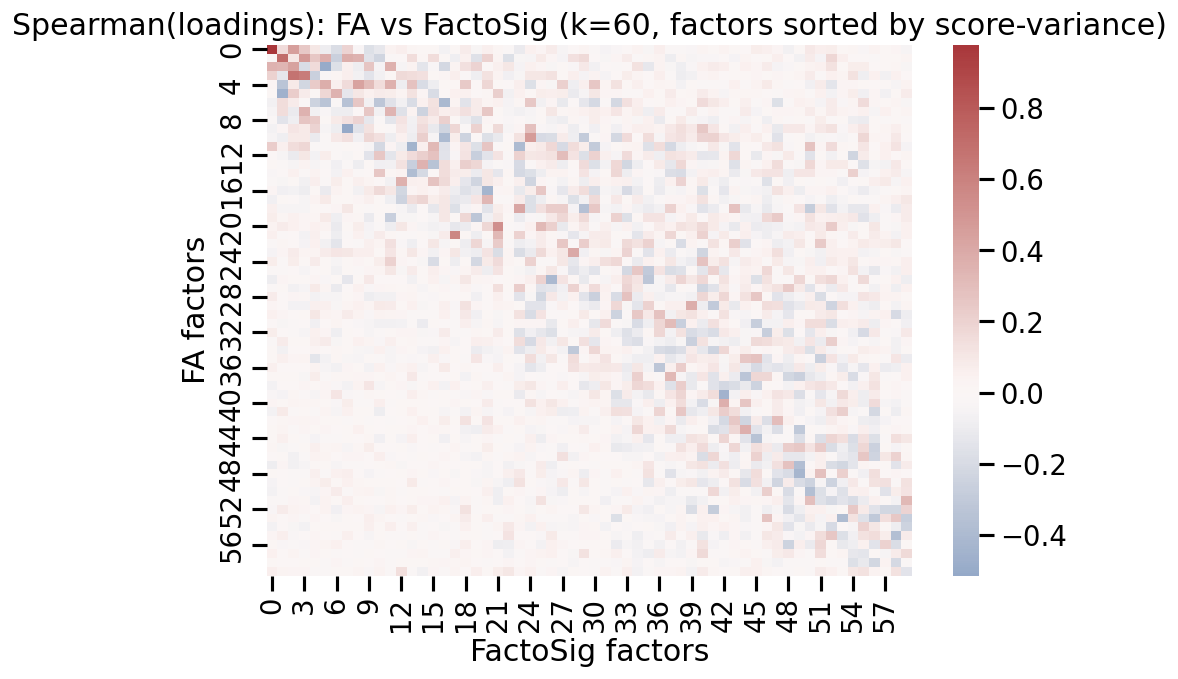

Saved: /home/minhang/mds_project/sc_classification/experiments/20260211_212806_plan0_k_sweep_60_none_hvg_c06f4886/analysis/plan0/prelim_k_compare_notebook/spearman_heatmap_fa_vs_factosig_k60.png
k=60: FA→FS best median=0.273, mean=0.310
k=60: FS→FA best median=0.281, mean=0.325



In [9]:
def spearman_corr_matrix(La: np.ndarray, Lb: np.ndarray) -> np.ndarray:
    import scipy.stats as stats

    ka, kb = La.shape[1], Lb.shape[1]
    C = np.zeros((ka, kb), dtype=float)
    for i in range(ka):
        for j in range(kb):
            rho, _ = stats.spearmanr(La[:, i], Lb[:, j])
            C[i, j] = float(rho)
    return C


for k in [20, 40, 60]:
    La = DR[(k, "fa")]["L_sorted"]
    Lb = DR[(k, "factosig")]["L_sorted"]
    C = spearman_corr_matrix(La, Lb)

    plt.figure(figsize=(8, 6))
    sns.heatmap(C, cmap="vlag", center=0)
    plt.title(f"Spearman(loadings): FA vs FactoSig (k={k}, factors sorted by score-variance)")
    plt.xlabel("FactoSig factors")
    plt.ylabel("FA factors")
    plt.tight_layout()
    out = OUT_DIR / f"spearman_heatmap_fa_vs_factosig_k{k}.png"
    plt.savefig(out, dpi=160)
    plt.show()
    print("Saved:", out)

    best_fa = C.max(axis=1)
    best_fs = C.max(axis=0)
    print(f"k={k}: FA→FS best median={np.median(best_fa):.3f}, mean={np.mean(best_fa):.3f}")
    print(f"k={k}: FS→FA best median={np.median(best_fs):.3f}, mean={np.mean(best_fs):.3f}")
    print()


POS_LABEL mapping: {'POS_LABEL': 'cancer', 'LABEL_COL': 'CN.label'}


,k,method,top_corr_factor_idx_sorted_1based,corr,abs_corr
0,40,fa,21,0.496466,0.496466
1,60,fa,22,0.488940,0.488940
2,40,factosig,19,0.584797,0.584797
3,60,factosig,18,0.579771,0.579771



Top-loading genes for fa K=40 factor#21 (corr=0.496): /home/minhang/mds_project/sc_classification/experiments/20260211_212806_plan0_k_sweep_60_none_hvg_c06f4886/analysis/plan0/prelim_k_compare_notebook/top_loading_genes_maxcorr_fa_k40_factor21.csv


,k,method,factor_idx_sorted_1based,corr_with_label,rank,gene,loading,abs_loading
0,40,fa,21,0.496466,1,COL4A5,0.668331,0.668331
1,40,fa,21,0.496466,2,KCNIP1,0.570373,0.570373
2,40,fa,21,0.496466,3,THSD7A,0.479014,0.479014
3,40,fa,21,0.496466,4,AR,0.470977,0.470977
4,40,fa,21,0.496466,5,CTNNA3,0.464980,0.464980
5,40,fa,21,0.496466,6,AC092969.1,0.452755,0.452755
6,40,fa,21,0.496466,7,AC008568.1,0.452612,0.452612
7,40,fa,21,0.496466,8,AGMO,0.430583,0.430583
8,40,fa,21,0.496466,9,LINC02147,0.418887,0.418887
9,40,fa,21,0.496466,10,MSC-AS1,0.401512,0.401512



Top-loading genes for factosig K=40 factor#19 (corr=0.585): /home/minhang/mds_project/sc_classification/experiments/20260211_212806_plan0_k_sweep_60_none_hvg_c06f4886/analysis/plan0/prelim_k_compare_notebook/top_loading_genes_maxcorr_factosig_k40_factor19.csv


,k,method,factor_idx_sorted_1based,corr_with_label,rank,gene,loading,abs_loading
0,40,factosig,19,0.584797,1,COL4A5,0.784440,0.784440
1,40,factosig,19,0.584797,2,KCNIP1,0.668540,0.668540
2,40,factosig,19,0.584797,3,THSD7A,0.575107,0.575107
3,40,factosig,19,0.584797,4,AR,0.558838,0.558838
4,40,factosig,19,0.584797,5,AC008568.1,0.545803,0.545803
5,40,factosig,19,0.584797,6,CTNNA3,0.544455,0.544455
6,40,factosig,19,0.584797,7,AC092969.1,0.535209,0.535209
7,40,factosig,19,0.584797,8,LINC02147,0.513532,0.513532
8,40,factosig,19,0.584797,9,AGMO,0.502615,0.502615
9,40,factosig,19,0.584797,10,MSC-AS1,0.471316,0.471316



Top-loading genes for fa K=60 factor#22 (corr=0.489): /home/minhang/mds_project/sc_classification/experiments/20260211_212806_plan0_k_sweep_60_none_hvg_c06f4886/analysis/plan0/prelim_k_compare_notebook/top_loading_genes_maxcorr_fa_k60_factor22.csv


,k,method,factor_idx_sorted_1based,corr_with_label,rank,gene,loading,abs_loading
0,60,fa,22,0.48894,1,COL4A5,0.658418,0.658418
1,60,fa,22,0.48894,2,KCNIP1,0.561480,0.561480
2,60,fa,22,0.48894,3,THSD7A,0.472298,0.472298
3,60,fa,22,0.48894,4,AR,0.464373,0.464373
4,60,fa,22,0.48894,5,CTNNA3,0.457986,0.457986
5,60,fa,22,0.48894,6,AC092969.1,0.447199,0.447199
6,60,fa,22,0.48894,7,AC008568.1,0.446322,0.446322
7,60,fa,22,0.48894,8,AGMO,0.423830,0.423830
8,60,fa,22,0.48894,9,LINC02147,0.412693,0.412693
9,60,fa,22,0.48894,10,MSC-AS1,0.396041,0.396041



Top-loading genes for factosig K=60 factor#18 (corr=0.580): /home/minhang/mds_project/sc_classification/experiments/20260211_212806_plan0_k_sweep_60_none_hvg_c06f4886/analysis/plan0/prelim_k_compare_notebook/top_loading_genes_maxcorr_factosig_k60_factor18.csv


,k,method,factor_idx_sorted_1based,corr_with_label,rank,gene,loading,abs_loading
0,60,factosig,18,0.579771,1,COL4A5,0.786363,0.786363
1,60,factosig,18,0.579771,2,KCNIP1,0.671512,0.671512
2,60,factosig,18,0.579771,3,THSD7A,0.575786,0.575786
3,60,factosig,18,0.579771,4,AR,0.561148,0.561148
4,60,factosig,18,0.579771,5,AC008568.1,0.547335,0.547335
5,60,factosig,18,0.579771,6,CTNNA3,0.544221,0.544221
6,60,factosig,18,0.579771,7,AC092969.1,0.537387,0.537387
7,60,factosig,18,0.579771,8,LINC02147,0.511045,0.511045
8,60,factosig,18,0.579771,9,AGMO,0.505008,0.505008
9,60,factosig,18,0.579771,10,MSC-AS1,0.472881,0.472881


K=40 detected confounder columns: {'patient': 'patient', 'cellType': 'predicted.annotation', 'pseudoTime': 'predicted.pseudotime', 'collectionTime': 'Time', 'n_counts': 'nCount_RNA', 'pct_mt': 'percent.mt', 'batch': 'batch'}
K=60 detected confounder columns: {'patient': 'patient', 'cellType': 'predicted.annotation', 'pseudoTime': 'predicted.pseudotime', 'collectionTime': 'Time', 'n_counts': 'nCount_RNA', 'pct_mt': 'percent.mt', 'batch': 'batch'}


,k,method,factor_idx_sorted_1based,corr_with_label,corr_pseudoTime,corr_collectionTime,corr_n_counts,corr_pct_mt,r2_patient,r2_cellType,r2_batch
0,40,fa,21,0.496466,-0.048286,NaN,0.005783,-0.023377,0.197535,0.040778,0.031929
1,60,fa,22,0.488940,-0.044538,NaN,0.005951,-0.018246,0.194082,0.041039,0.030113
2,40,factosig,19,0.584797,-0.064779,NaN,0.013052,-0.053605,0.240235,0.021501,0.028125
3,60,factosig,18,0.579771,-0.067074,NaN,0.011311,-0.063695,0.238948,0.019462,0.027406


,k,method,patient,n_cells,top_factor_idx_sorted_1based,max_abs_corr,global_top_factor_idx_sorted_1based
7,40,fa,P09,17126,36,0.094716,21
0,40,fa,P01,11860,10,0.075604,21
8,40,fa,P13,5774,12,0.041284,21
4,40,fa,P05,4359,10,0.064128,21
5,40,fa,P06,3259,6,0.112537,21
2,40,fa,P03,2327,21,0.789570,21
6,40,fa,P07,2185,2,0.100890,21
1,40,fa,P02,1462,32,0.553337,21
3,40,fa,P04,1128,30,0.378511,21
25,60,fa,P09,17126,54,0.400993,22


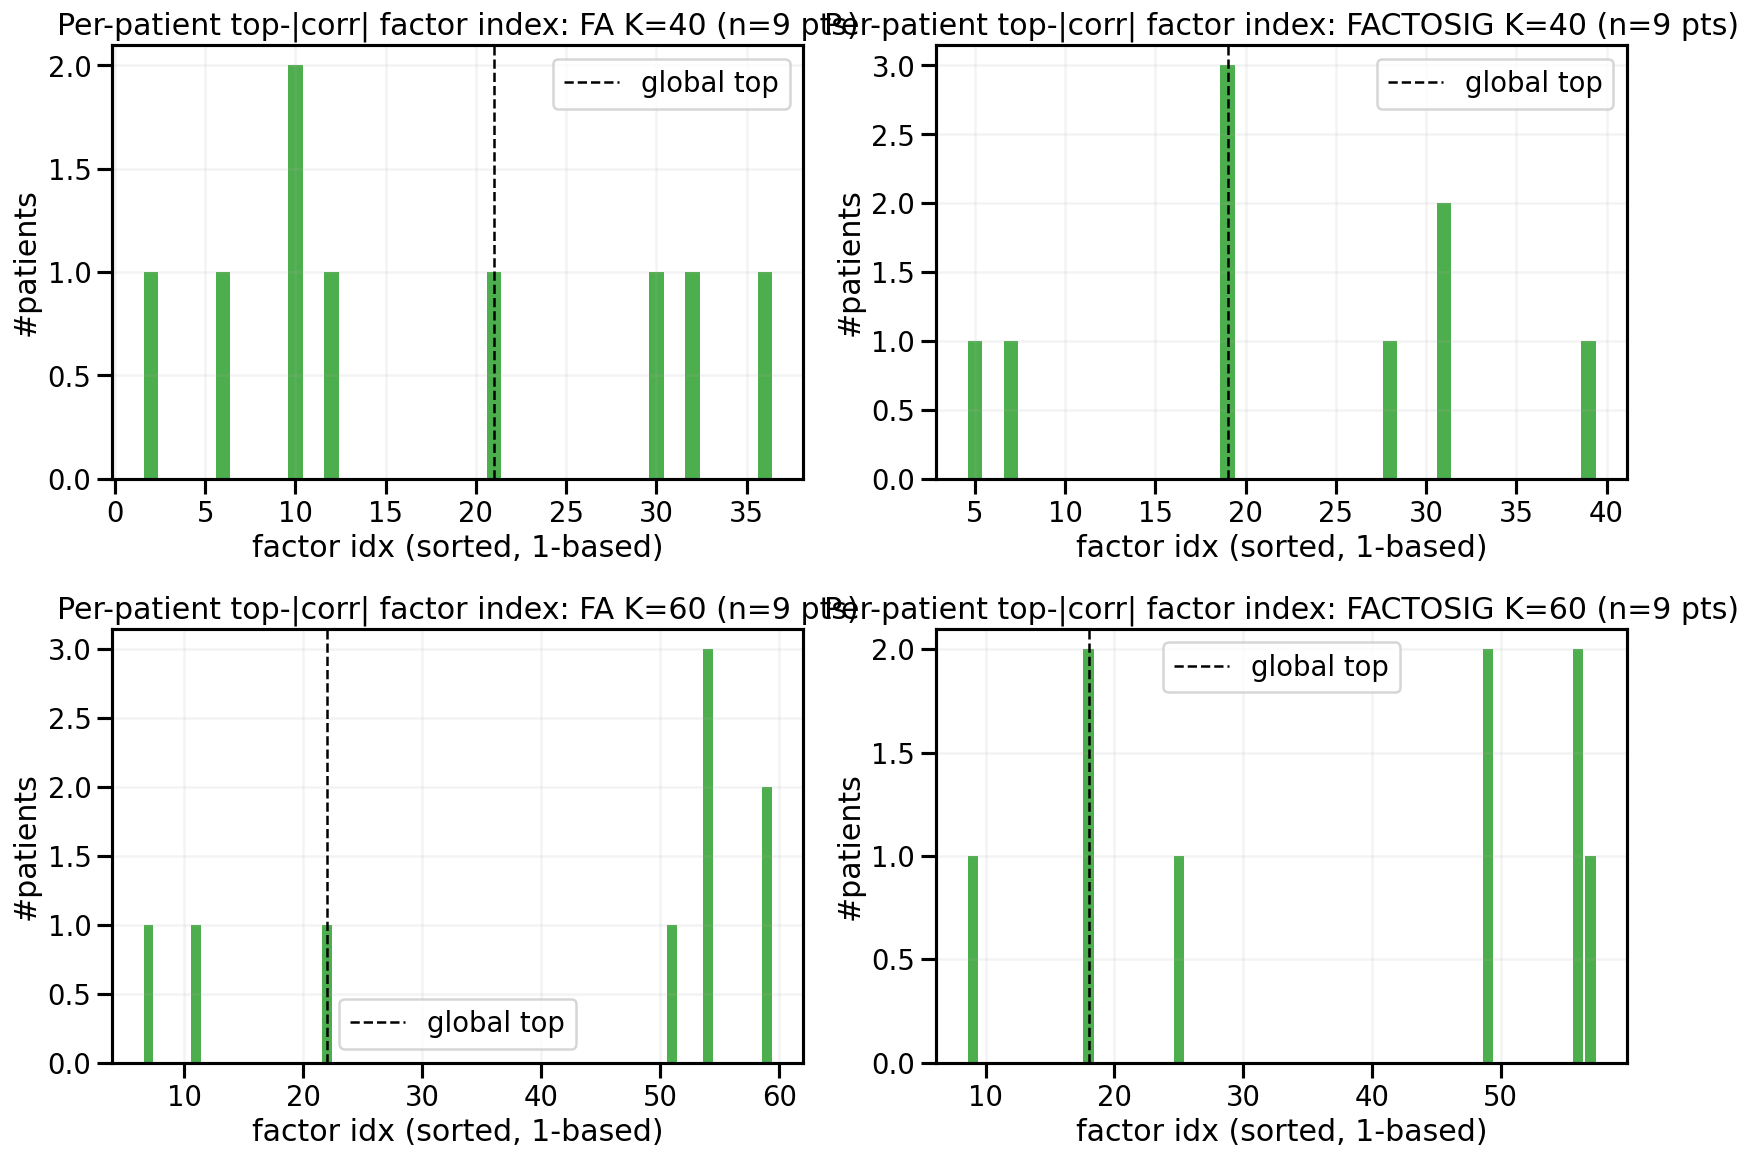

Saved: /home/minhang/mds_project/sc_classification/experiments/20260211_212806_plan0_k_sweep_60_none_hvg_c06f4886/analysis/plan0/prelim_k_compare_notebook/per_patient_top_corr_factor_index_counts_k40_k60.png


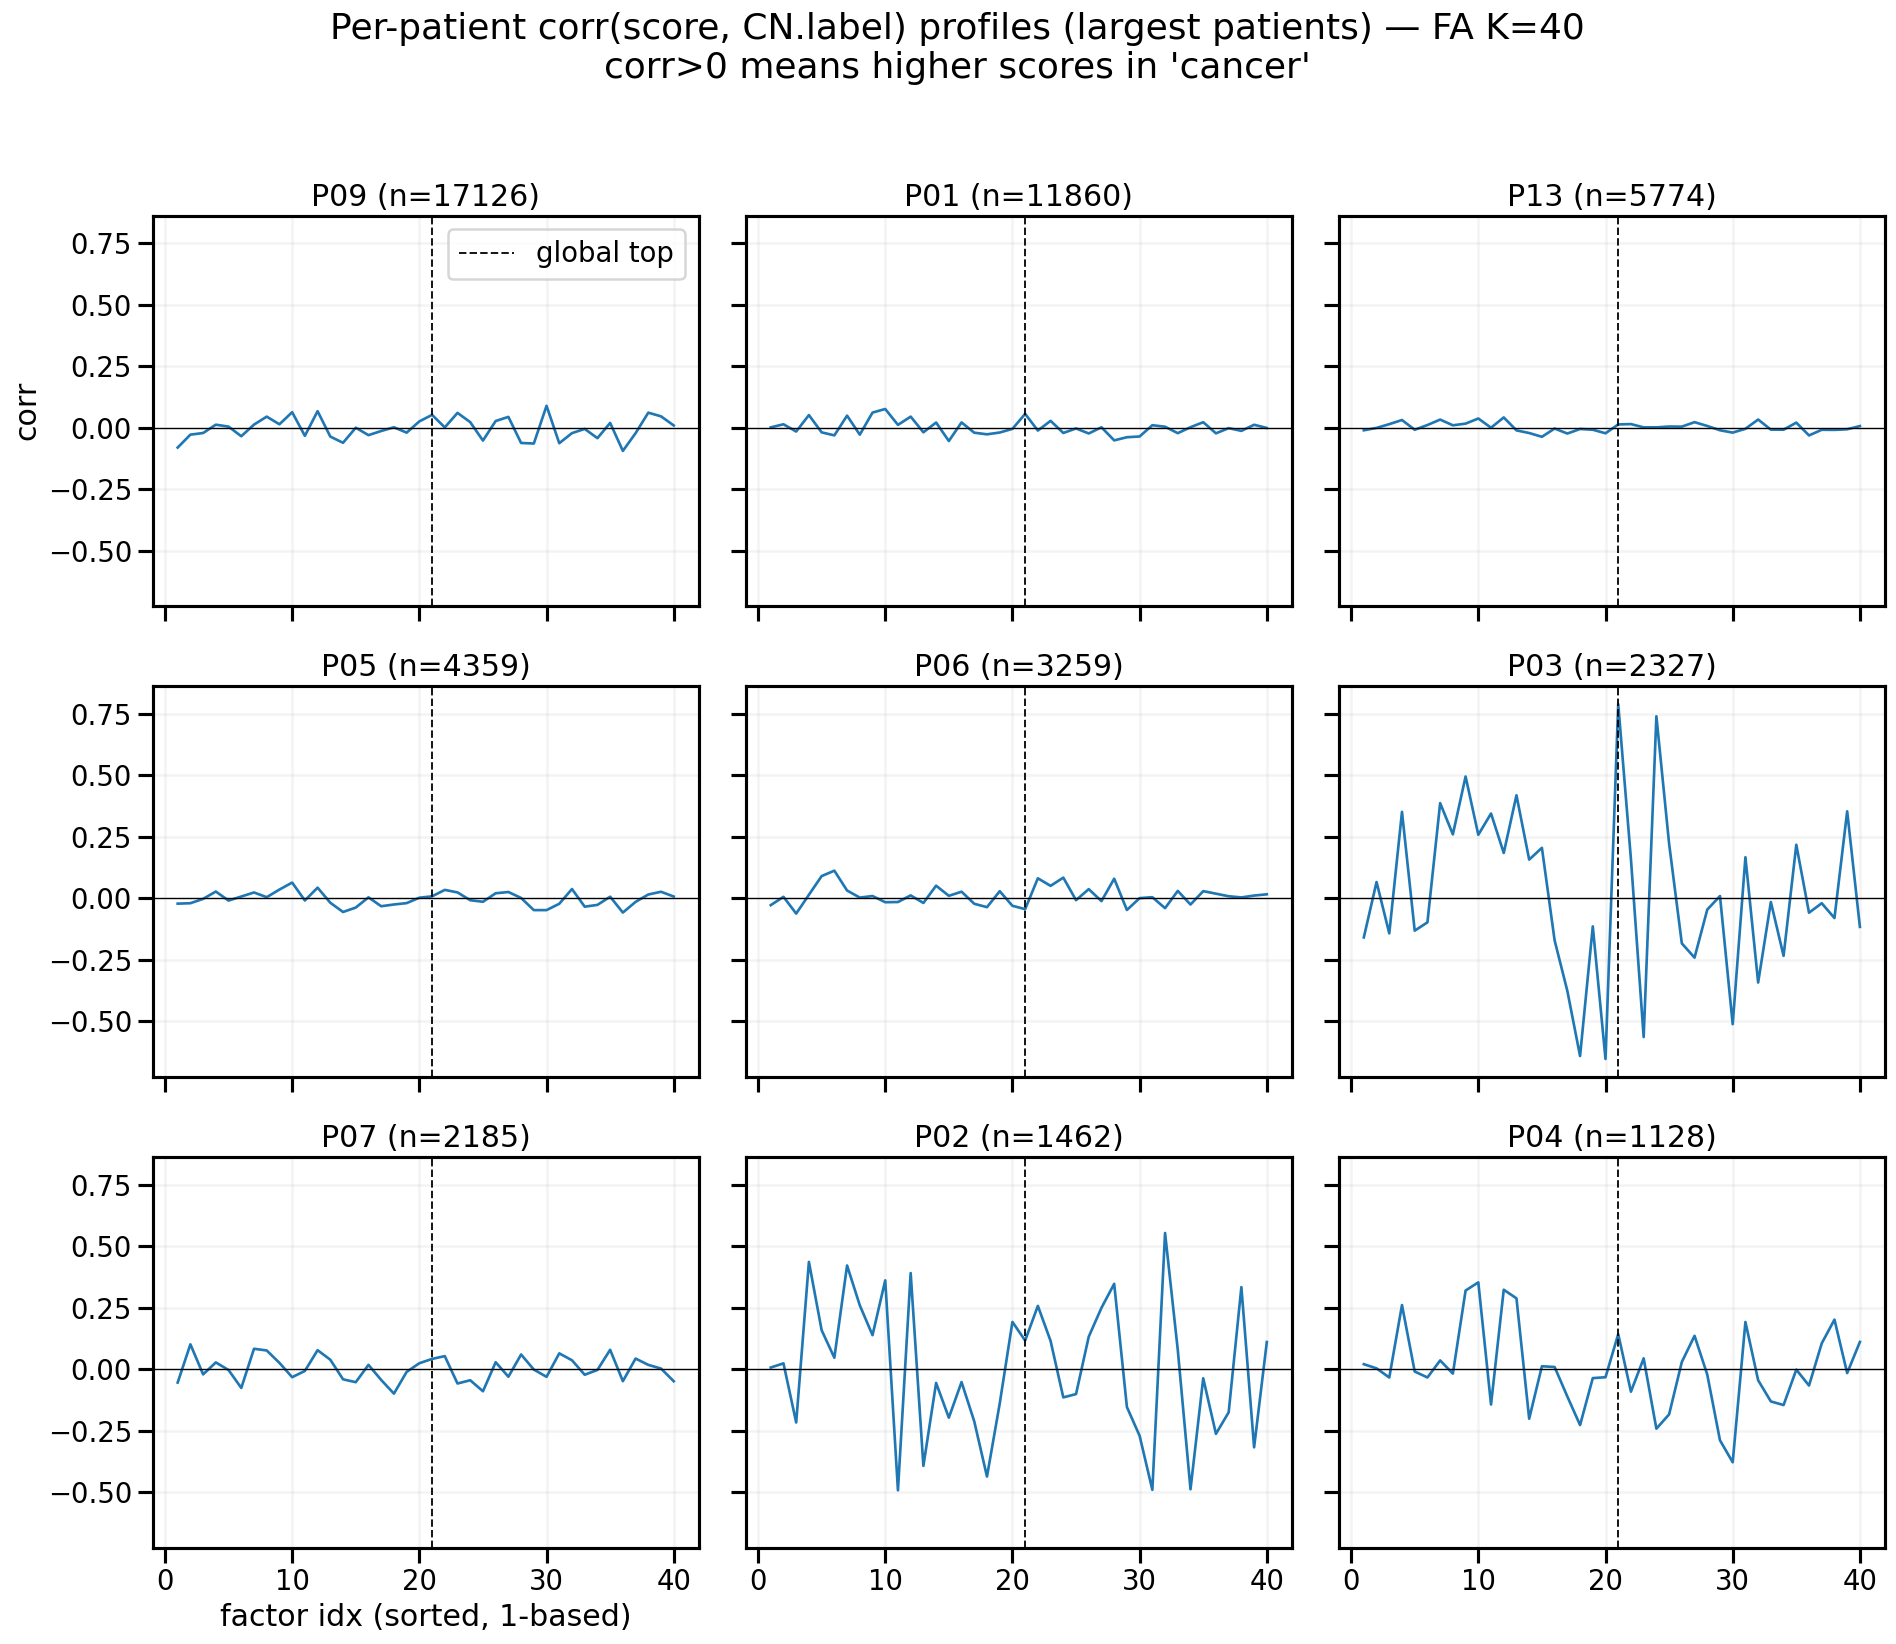

Saved: /home/minhang/mds_project/sc_classification/experiments/20260211_212806_plan0_k_sweep_60_none_hvg_c06f4886/analysis/plan0/prelim_k_compare_notebook/per_patient_corr_profiles_fa_k40.png


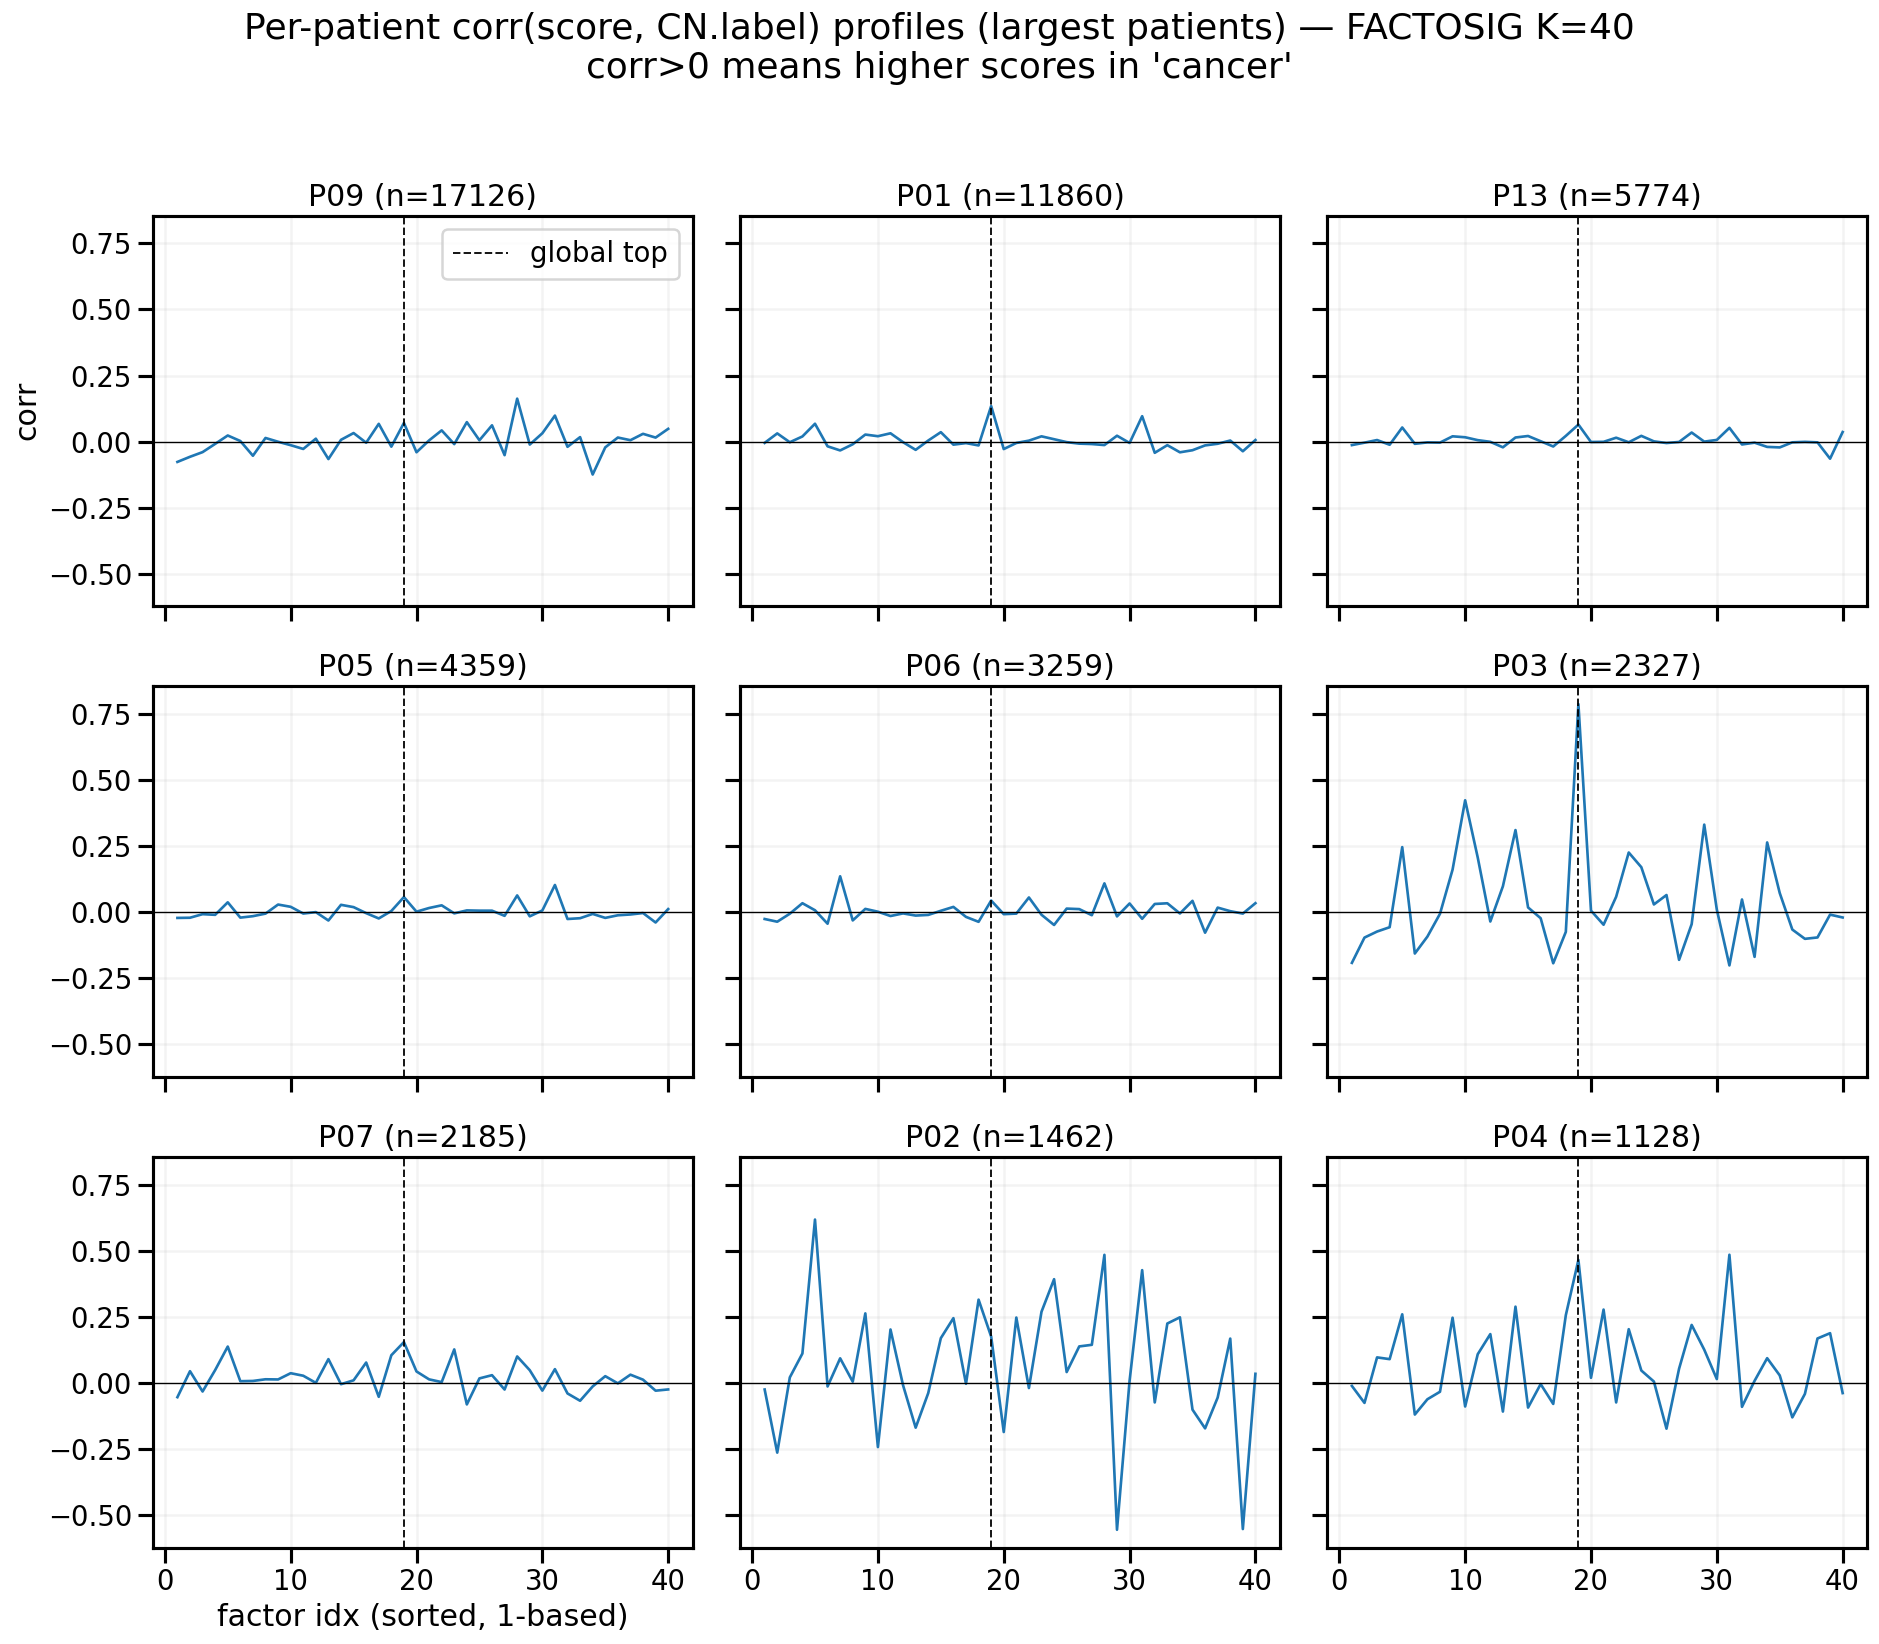

Saved: /home/minhang/mds_project/sc_classification/experiments/20260211_212806_plan0_k_sweep_60_none_hvg_c06f4886/analysis/plan0/prelim_k_compare_notebook/per_patient_corr_profiles_factosig_k40.png


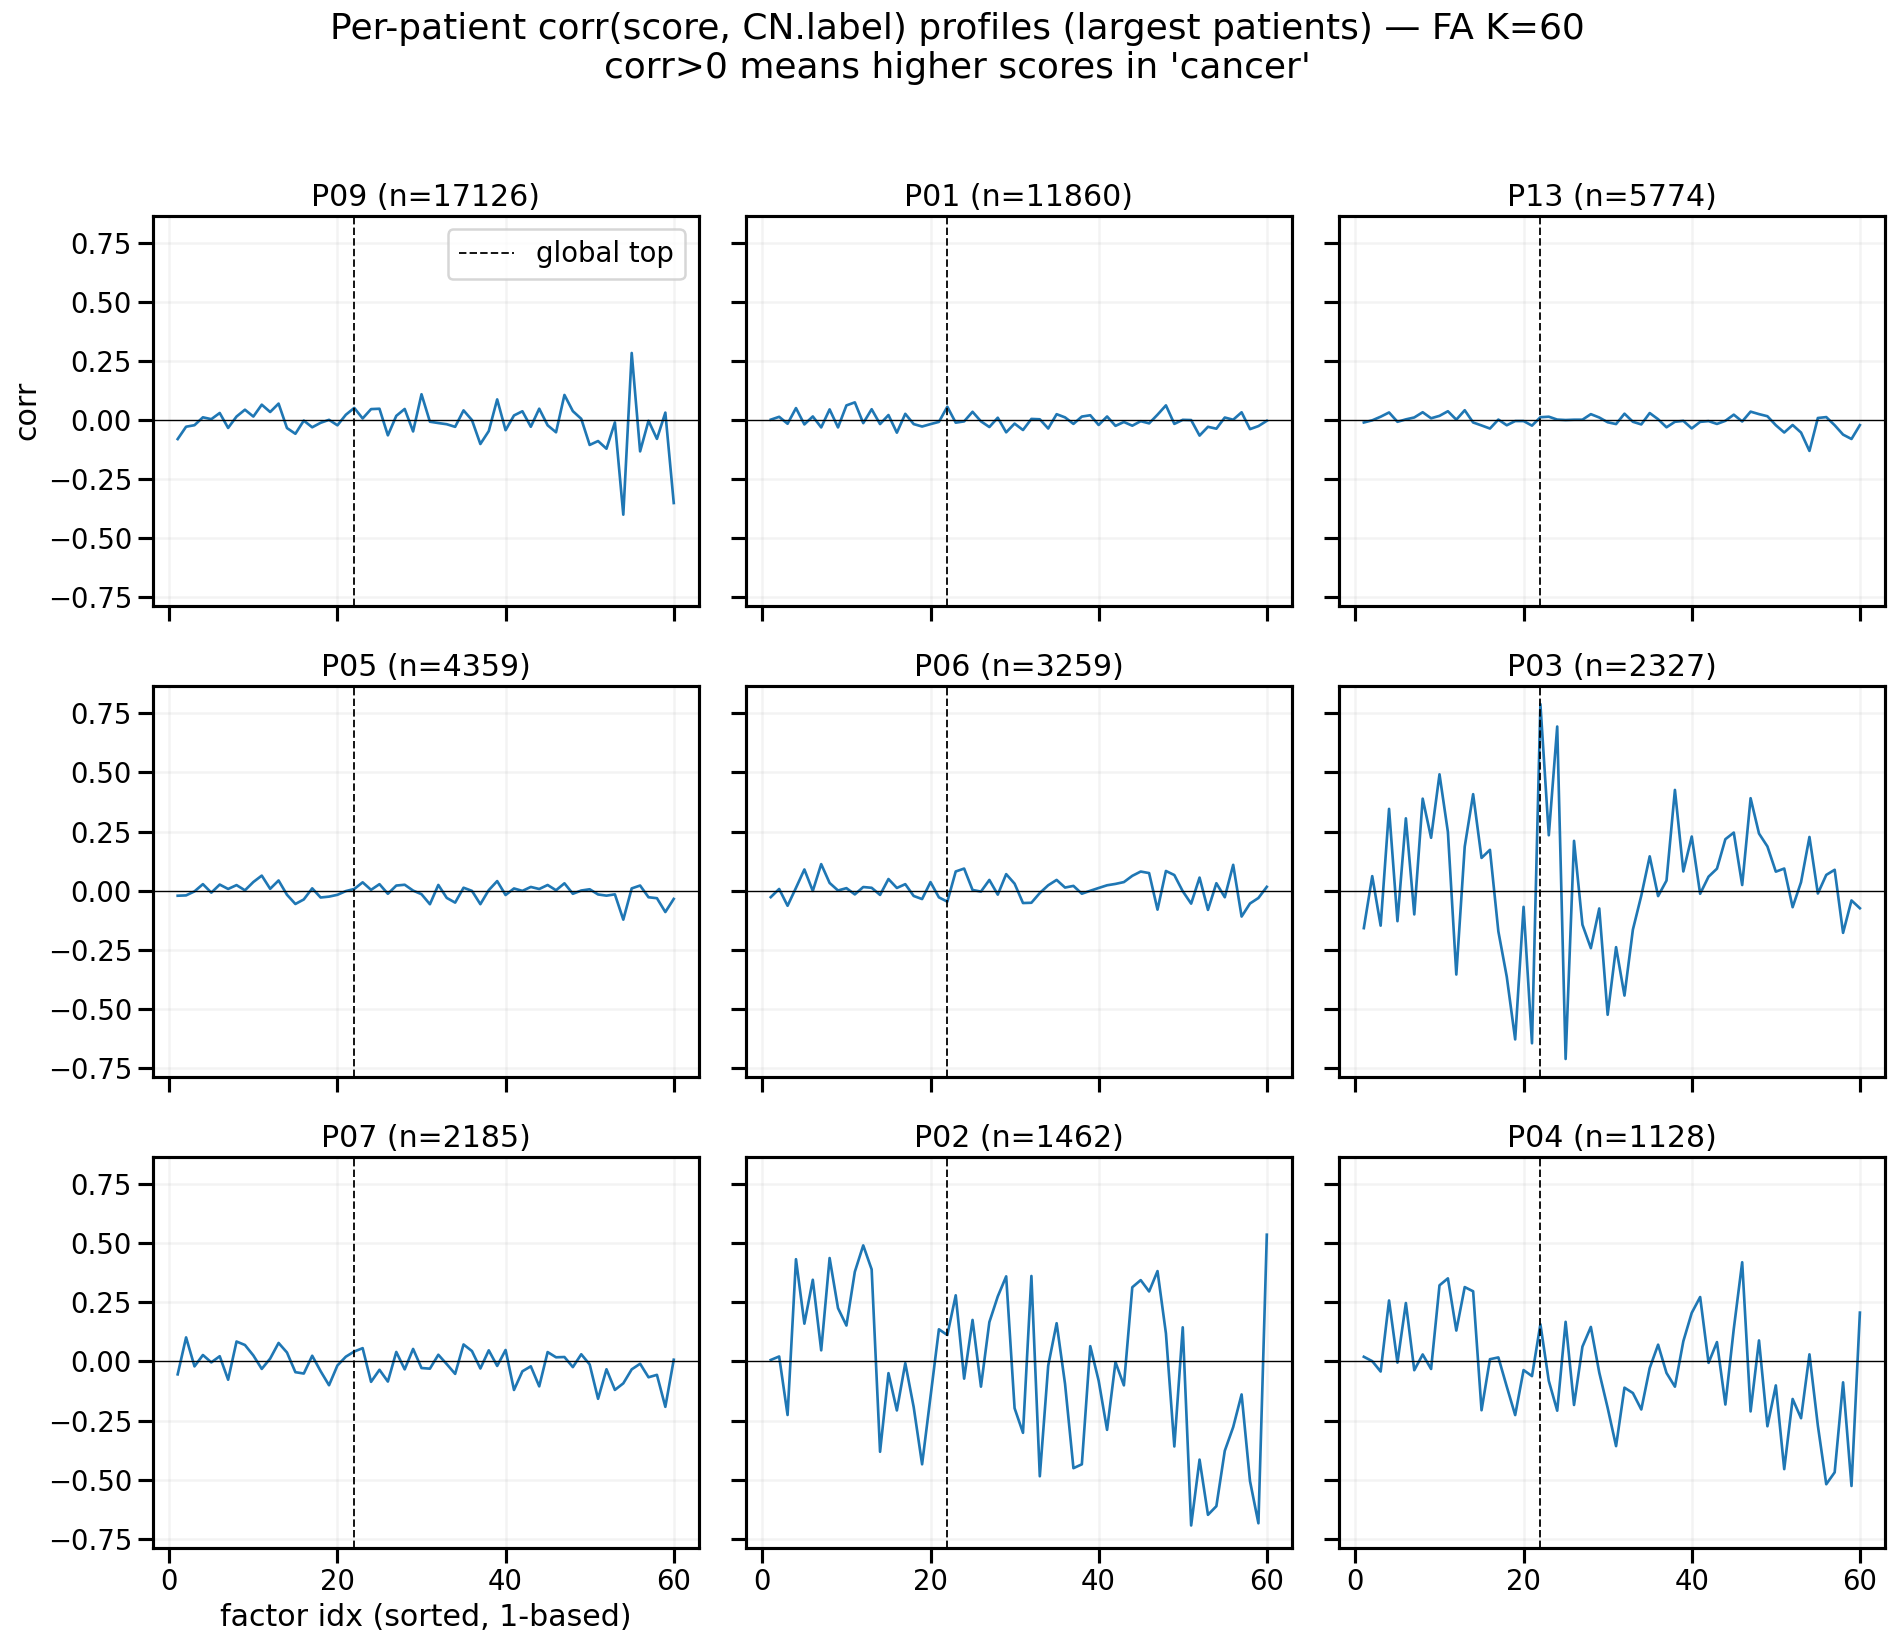

Saved: /home/minhang/mds_project/sc_classification/experiments/20260211_212806_plan0_k_sweep_60_none_hvg_c06f4886/analysis/plan0/prelim_k_compare_notebook/per_patient_corr_profiles_fa_k60.png


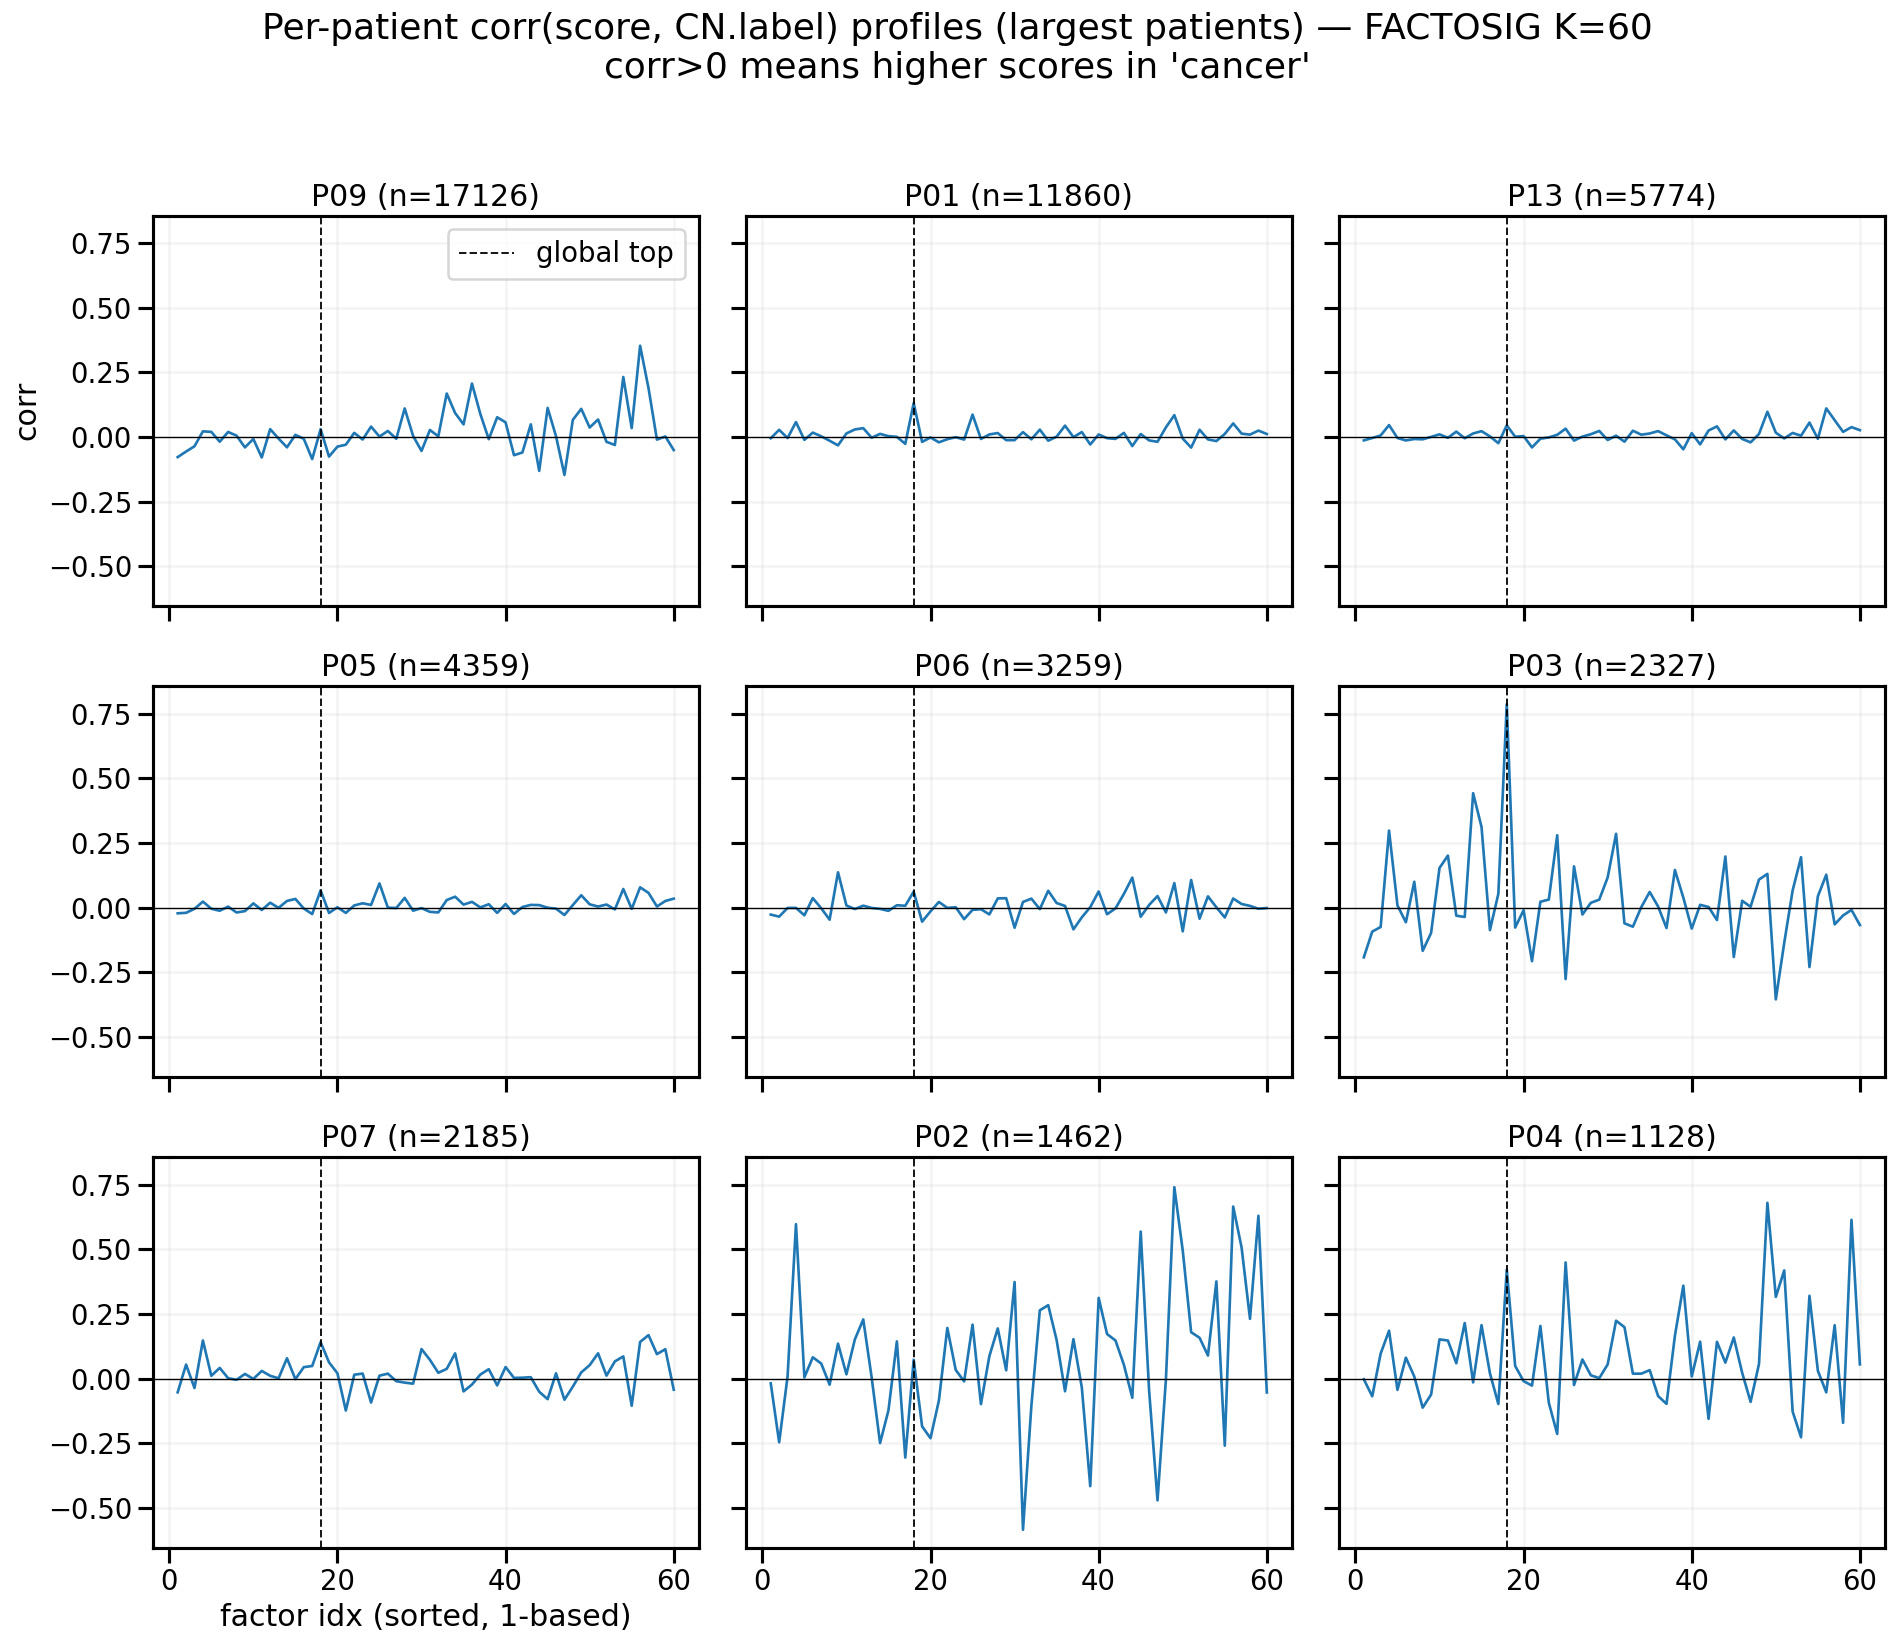

Saved: /home/minhang/mds_project/sc_classification/experiments/20260211_212806_plan0_k_sweep_60_none_hvg_c06f4886/analysis/plan0/prelim_k_compare_notebook/per_patient_corr_profiles_factosig_k60.png


In [10]:
# --- Extensions: top-genes + confounder checks for max-|corr| factors ---

from collections import defaultdict


def top_loading_genes(var_names: np.ndarray, loadings: np.ndarray, top_n: int = 30):
    df = pd.DataFrame(
        {
            "gene": var_names,
            "loading": loadings.astype(float),
            "abs_loading": np.abs(loadings.astype(float)),
        }
    ).sort_values("abs_loading", ascending=False)
    df.insert(0, "rank", np.arange(1, len(df) + 1))
    return df.head(top_n).reset_index(drop=True)


def top_communality_genes(var_names: np.ndarray, L: np.ndarray, top_n: int = 30):
    comm = (L.astype(float) ** 2).sum(axis=1)
    df = pd.DataFrame({"gene": var_names, "communality": comm, "log10_1p": np.log10(1.0 + comm)})
    df = df.sort_values("communality", ascending=False)
    df.insert(0, "rank", np.arange(1, len(df) + 1))
    return df.head(top_n).reset_index(drop=True)


# 1) Save communality top-genes per method/K
rows = []
for k in [20, 40, 60]:
    for m in ["fa", "factosig"]:
        var_names = DR[(k, m)]["var_names"]
        Ls = DR[(k, m)]["L_sorted"]
        top_comm = top_communality_genes(var_names, Ls, top_n=30)
        out = OUT_DIR / f"top_communality_genes_{m}_k{k}.csv"
        top_comm.to_csv(out, index=False)
        rows.append({"k": k, "method": m, "path": str(out)})

pd.DataFrame(rows)


# 2) Identify max-|corr| factor (sorted index) for K=40/60 and export top-loading genes
TOP = {}  # (k, m) -> dict(idx0, idx1, corr, sign)
for k in [40, 60]:
    for m in ["fa", "factosig"]:
        Zs = DR[(k, m)]["Z_sorted"]
        y = DR[(k, m)]["y"]
        corr = factor_label_corrs(Zs, y)
        idx0 = int(np.argmax(np.abs(corr)))
        TOP[(k, m)] = {
            "k": int(k),
            "method": m,
            "top_corr_factor_idx_sorted_1based": int(idx0 + 1),
            "corr": float(corr[idx0]),
            "abs_corr": float(abs(corr[idx0])),
        }

TOP_df = pd.DataFrame(list(TOP.values())).sort_values(["method", "k"]).reset_index(drop=True)
print("POS_LABEL mapping:", {"POS_LABEL": POS_LABEL, "LABEL_COL": LABEL_COL})
display(TOP_df)
TOP_df.to_csv(OUT_DIR / "max_abs_corr_factor_summary_k40_k60.csv", index=False)

# Top-loading genes for those max-|corr| factors
for (k, m), rec in TOP.items():
    idx1 = rec["top_corr_factor_idx_sorted_1based"]
    idx0 = idx1 - 1
    var_names = DR[(k, m)]["var_names"]
    Ls = DR[(k, m)]["L_sorted"]
    load = Ls[:, idx0]
    df_top = top_loading_genes(var_names, load, top_n=40)
    df_top.insert(0, "k", int(k))
    df_top.insert(1, "method", m)
    df_top.insert(2, "factor_idx_sorted_1based", int(idx1))
    df_top.insert(3, "corr_with_label", float(rec["corr"]))
    out = OUT_DIR / f"top_loading_genes_maxcorr_{m}_k{k}_factor{idx1}.csv"
    df_top.to_csv(out, index=False)
    print(f"\nTop-loading genes for {m} K={k} factor#{idx1} (corr={rec['corr']:.3f}): {out}")
    display(df_top.head(15))


# 3) Confounder association checks (global, for max-|corr| factors)
#    Note: these are association diagnostics (mostly in-sample) to detect obvious technical/patient axes.

def _pick_first(ad, candidates):
    for c in candidates:
        if c in ad.obs.columns:
            return c
    return None


def _as_numeric(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s, errors="coerce")


def assoc_numeric(z: np.ndarray, x: pd.Series) -> float:
    x = _as_numeric(x)
    mask = np.isfinite(z) & np.isfinite(x.to_numpy(dtype=float))
    if mask.sum() < 10:
        return float("nan")
    z0 = z[mask] - float(np.mean(z[mask]))
    x0 = x.to_numpy(dtype=float)[mask] - float(np.nanmean(x.to_numpy(dtype=float)[mask]))
    denom = (np.linalg.norm(z0) * np.linalg.norm(x0)) + 1e-12
    return float((z0 * x0).sum() / denom)


def assoc_categorical_r2(z: np.ndarray, x: pd.Series, max_levels: int = 50) -> float:
    try:
        from sklearn.linear_model import Ridge
    except Exception:
        return float("nan")

    x = x.astype(str).fillna("NA")
    vc = x.value_counts(dropna=False)
    keep = set(vc.head(max_levels).index)
    x2 = x.where(x.isin(keep), other="OTHER")

    X = pd.get_dummies(x2, drop_first=True)
    if X.shape[1] == 0:
        return float("nan")

    mask = np.isfinite(z)
    if mask.sum() < 20:
        return float("nan")

    model = Ridge(alpha=1.0)
    model.fit(X.to_numpy(dtype=float)[mask], z[mask])
    return float(model.score(X.to_numpy(dtype=float)[mask], z[mask]))


# Candidate confounder columns (auto-detected if present)
CANDS = {
    "patient": ["patient", "patient_id", "donor", "subject", "pt", "sample", "patientID", "Patient"],
    "cellType": ["predicted.annotation", "cellType", "cell_type", "CellType", "celltype", "cell_type_l2"],
    "pseudoTime": ["predicted.pseudotime", "pseudoTime", "pseudotime", "PseudoTime"],
    "collectionTime": ["collectionTime", "collection_time", "time", "Time"],
    "n_counts": ["n_counts", "total_counts", "nCount_RNA"],
    "pct_mt": ["percent.mt", "pct_mt", "percent_mt", "pct_counts_mt", "mt_frac"],
    "batch": ["batch", "Lane", "chemistry", "tech", "Tech", "assay", "library", "lane"],
}

conf_rows = []
for k in [40, 60]:
    ad = load_adata_k(k, backed=True)
    cols = {name: _pick_first(ad, cand) for name, cand in CANDS.items()}
    print(f"K={k} detected confounder columns:", cols)

    for m in ["fa", "factosig"]:
        idx1 = TOP[(k, m)]["top_corr_factor_idx_sorted_1based"]
        z = DR[(k, m)]["Z_sorted"][:, idx1 - 1].astype(float)

        rec = {
            "k": int(k),
            "method": m,
            "factor_idx_sorted_1based": int(idx1),
            "corr_with_label": float(TOP[(k, m)]["corr"]),
        }

        # numeric
        for nm in ["pseudoTime", "collectionTime", "n_counts", "pct_mt"]:
            c = cols.get(nm)
            if c is None:
                rec[f"corr_{nm}"] = float("nan")
            else:
                rec[f"corr_{nm}"] = assoc_numeric(z, ad.obs[c])

        # categorical as in-sample R^2 (one-hot + ridge)
        for nm in ["patient", "cellType", "batch"]:
            c = cols.get(nm)
            if c is None:
                rec[f"r2_{nm}"] = float("nan")
            else:
                rec[f"r2_{nm}"] = assoc_categorical_r2(z, ad.obs[c], max_levels=50)

        conf_rows.append(rec)

conf_df = pd.DataFrame(conf_rows).sort_values(["method", "k"]).reset_index(drop=True)
display(conf_df)
conf_df.to_csv(OUT_DIR / "maxcorr_factor_confounder_associations_k40_k60.csv", index=False)


# 4) Per-patient: does the max-|corr| factor index stay similar?
#    (Only patients with both classes present are included.)

def per_patient_top_corr_index(Zs: np.ndarray, y: np.ndarray, patient: pd.Series):
    out = []
    # Ensure integer indexing for slicing Z/y (obs_names are barcodes by default)
    patient = patient.astype(str).fillna("NA").reset_index(drop=True)
    for pid, idx in patient.groupby(patient).groups.items():
        ii = np.array(list(idx), dtype=int)
        yy = y[ii]
        if len(np.unique(yy)) < 2:
            continue
        corr = factor_label_corrs(Zs[ii, :], yy)
        top = int(np.argmax(np.abs(corr))) + 1
        out.append({"patient": pid, "n_cells": int(len(ii)), "top_factor_idx_sorted_1based": top, "max_abs_corr": float(np.max(np.abs(corr)))})
    return pd.DataFrame(out)

pp_rows = []
for k in [40, 60]:
    ad = load_adata_k(k, backed=True)
    pcol = _pick_first(ad, CANDS["patient"])
    if pcol is None:
        print(f"K={k}: no patient column found; skipping per-patient summary")
        continue
    patient = ad.obs[pcol]

    for m in ["fa", "factosig"]:
        Zs = DR[(k, m)]["Z_sorted"]
        y = DR[(k, m)]["y"]
        df_pp = per_patient_top_corr_index(Zs, y, patient)
        if len(df_pp) == 0:
            continue
        df_pp.insert(0, "k", int(k))
        df_pp.insert(1, "method", m)
        df_pp["global_top_factor_idx_sorted_1based"] = int(TOP[(k, m)]["top_corr_factor_idx_sorted_1based"])
        pp_rows.append(df_pp)

if len(pp_rows) > 0:
    pp_df = pd.concat(pp_rows, ignore_index=True)
    display(pp_df.sort_values(["method", "k", "n_cells"], ascending=[True, True, False]).head(25))
    pp_df.to_csv(OUT_DIR / "per_patient_top_corr_factor_index_k40_k60.csv", index=False)

    # simple count plot: how often each factor index is top
    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=False)
    axes = np.array(axes)

    for i, k in enumerate([40, 60]):
        for j, m in enumerate(["fa", "factosig"]):
            ax = axes[i, j]
            sub = pp_df[(pp_df["k"] == k) & (pp_df["method"] == m)]
            if len(sub) == 0:
                ax.axis("off")
                continue
            vc = sub["top_factor_idx_sorted_1based"].value_counts().sort_index()
            ax.bar(vc.index.to_numpy(), vc.to_numpy(), color="#2ca02c", alpha=0.85)
            ax.axvline(TOP[(k, m)]["top_corr_factor_idx_sorted_1based"], color="k", lw=1.5, linestyle="--", label="global top")
            ax.set_title(f"Per-patient top-|corr| factor index: {m.upper()} K={k} (n={len(sub)} pts)")
            ax.set_xlabel("factor idx (sorted, 1-based)")
            ax.set_ylabel("#patients")
            ax.legend(frameon=True)
            ax.grid(True, alpha=0.15)

    plt.tight_layout()
    fig_path = OUT_DIR / "per_patient_top_corr_factor_index_counts_k40_k60.png"
    plt.savefig(fig_path, dpi=160)
    plt.show()
    print("Saved:", fig_path)

    # Optional: per-patient corr profiles (single-axis) for a few largest patients
    import math

    def plot_patient_corr_profiles(k: int, m: str, top_n: int = 9):
        ad = load_adata_k(k, backed=True)
        pcol = _pick_first(ad, CANDS["patient"])
        if pcol is None:
            return None
        # Use integer indexing for slicing Z/y
        patient = ad.obs[pcol].astype(str).fillna("NA").reset_index(drop=True)
        Zs = DR[(k, m)]["Z_sorted"]
        y = DR[(k, m)]["y"]

        pats = []
        for pid, idx in patient.groupby(patient).groups.items():
            ii = np.array(list(idx), dtype=int)
            if len(np.unique(y[ii])) < 2:
                continue
            pats.append((pid, int(len(ii))))
        pats = sorted(pats, key=lambda t: t[1], reverse=True)[:top_n]
        if len(pats) == 0:
            return None

        ncols = 3
        nrows = int(math.ceil(len(pats) / ncols))
        fig, axes = plt.subplots(nrows, ncols, figsize=(16, 4.5 * nrows), sharex=True, sharey=True)
        axes = np.atleast_1d(axes).reshape(nrows, ncols)

        # set shared y-lims using these patients
        allc = []
        for pid, _n in pats:
            ii = np.array(list(patient[patient == pid].index), dtype=int)
            allc.append(factor_label_corrs(Zs[ii, :], y[ii]))
        cmin = min(float(np.min(c)) for c in allc)
        cmax = max(float(np.max(c)) for c in allc)
        pad = 0.05 * (cmax - cmin + 1e-12)
        ylim = (cmin - pad, cmax + pad)

        for ax in axes.ravel():
            ax.axis("off")

        for ax, (pid, n_cells) in zip(axes.ravel(), pats):
            ax.axis("on")
            ii = np.array(list(patient[patient == pid].index), dtype=int)
            corr = factor_label_corrs(Zs[ii, :], y[ii])
            x = np.arange(1, len(corr) + 1)
            ax.plot(x, corr, lw=1.6, color="#1f77b4")
            ax.axhline(0, color="k", lw=0.8)
            ax.axvline(
                TOP[(k, m)]["top_corr_factor_idx_sorted_1based"],
                color="k",
                lw=1.2,
                linestyle="--",
                alpha=0.9,
                label="global top" if pid == pats[0][0] else None,
            )
            ax.set_title(f"{pid} (n={n_cells})")
            ax.set_ylim(*ylim)
            ax.grid(True, alpha=0.15)

        axes[-1, 0].set_xlabel("factor idx (sorted, 1-based)")
        axes[0, 0].set_ylabel("corr")
        if any(l.get_label() == "global top" for l in axes.ravel()[0].get_lines()):
            axes.ravel()[0].legend(frameon=True)

        fig.suptitle(
            f"Per-patient corr(score, {LABEL_COL}) profiles (largest patients) — {m.upper()} K={k}\n"
            f"corr>0 means higher scores in {POS_LABEL!r}",
            y=1.02,
        )
        plt.tight_layout()
        out = OUT_DIR / f"per_patient_corr_profiles_{m}_k{k}.png"
        plt.savefig(out, dpi=160, bbox_inches="tight")
        plt.show()
        print("Saved:", out)
        return out

    for k in [40, 60]:
        for m in ["fa", "factosig"]:
            plot_patient_corr_profiles(k, m, top_n=9)
